- Where appropriate, a parenthetical is included in the section heading to denote panel(s) to which said section pertains.
- Note that running the permutations may yield values slightly different from the manuscript.

# Setup

## Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
from glob import glob
import re
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import zscore, norm, rankdata
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from collections import Counter
from random import random

from matplotlib.patches import Rectangle

## Functions

In [2]:
# Convenience function for rounding and display of decimal values as scientific notation.
def formatx10(floatNum):
    floatNum = str(floatNum)
    if 'e' in floatNum:
        exp = str(int(floatNum[floatNum.index('e')+1:]))
        floatNum = floatNum[:floatNum.index('e')] + ' x 10' + r'$^{}$'.format(exp)
        floatNum = floatNum.replace('$^', '|||^{')
        floatNum = floatNum.replace('$', '}$')
        floatNum = floatNum.replace('|||', '$')
        return(floatNum)
    else:
        return(floatNum)

In [3]:
# Function to generate the kernel density over a list of observed data points.
def kdestimate(x, x_grid, bandwidth=None, **kwargs):
    if bandwidth == None:
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x_grid.max()*0.01, x_grid.max()*0.1, 20)},
                    cv=20)
        grid.fit(x[:, None])
        bandwidth = grid.best_params_['bandwidth']
        print('bandwidth =', bandwidth)
    
    kde = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde.fit(x[:, np.newaxis])
    log_pdf = kde.score_samples(x_grid[:, np.newaxis])
    
    return np.exp(log_pdf)

In [4]:
# Formatting function for plot axes.
# See http://matplotlib.org/examples/pylab_examples/spine_placement_demo.html
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')

    # Turn off ticks where there is no spine in arguments.
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [5]:
# Formatting function for removing plot frame.
def removeAxes(ax):
    ax.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,
    labelleft=False)

    ax.tick_params(
        axis='x',
        which='both',
        top=False,
        bottom=False,
        labelbottom=False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

## Dataframes

### shref

In [6]:
# shref contains the info about each hairpin
shref = pd.read_csv('ref/shref.csv')
print(shref.shape)
shref.head()

(2803, 28)


,id,shrna,seed,type,gene,chr,gWindowStart,gWindowEnd,snp,snpPos,...,pheno-r2d9,pheno-r2d12,pheno-r2d14,pheno-r2d16,pheno-r3d4,pheno-r3d6,pheno-r3d9,pheno-r3d12,pheno-r3d14,pheno-r3d16
0,sr0001,GCCAGCACTATACCATTGTT,AACAATG,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,1263,504,197,283,9648,4306,897,394,392,240
1,sr0002,CCGGACTATCTGCATAGCTT,AAGCTAT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,224,85,45,66,587,480,63,33,29,42
2,sr0003,CCTGATTCTATACTTTGTGA,TCACAAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,332,159,85,101,734,492,144,129,124,51
3,sr0004,GCTGAGATTGTGGTTGGTGA,TCACCAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,1029,547,195,315,10219,2908,474,290,252,191
4,sr0005,GATGCACTGACCCAGATTAA,TTAATCT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,304,146,71,62,5846,1231,151,21,80,55


### annoref

In [7]:
# annoref contains annotation information for each gene in the screen
annoref = pd.read_csv('ref/annoFinal.csv')
print(annoref.shape)
annoref.head()

(419, 17)


,gene,anno,exclude,chr,gWindowStart,gWindowEnd,snp,ldsnp,ldstart,ldend,rcsnp,rcstart,rcend,closestLDsnp,distanceToLD,closestRCsnp,distanceToRC
0,ABCF1,gwa,NaN,chr6,30429169.0,30599309.0,rs2097775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABO,gwa,NaN,chr9,136090562.0,136260630.0,rs579459,rs579459,136141870.0,136155000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACAD10,gwa,NaN,chr12,112013856.0,112188121.0,rs3184504,rs3184504,111833788.0,112883476.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACADS,gwa,NaN,chr12,121053570.0,121217811.0,rs3829290,rs3829290,121101152.0,121184931.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACD,gwa,NaN,chr16,67651414.0,67804718.0,rs2271294,rs2271294,67699948.0,68013471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### traitref

In [8]:
# traitref contains info for the snp-phenotype associations from van der Harst et al., 2012
traitref = pd.read_csv('ref/associatedTraits.csv')
print(traitref.shape)
traitref.head()

(8586, 12)


,SNP,Chr,Position,Allele1,Allele2,Freq1,Pheno,Effect,StdErr,Weight,P_value,GENE
0,rs1175550,1,3681388,a,g,0.76,MCHC,-0.0167,0.0043,50425,8.617000e-15,CCDC27
1,rs1175549,1,3681587,a,c,0.74,MCHC,-0.0171,0.0041,52093,1.348000e-14,CCDC27
2,rs2799182,1,3685860,t,c,0.52,MCHC,-0.0085,0.0035,52083,1.064000e-07,LRRC47
3,rs8379,1,3686750,a,c,0.52,MCHC,-0.0096,0.0034,56473,1.761000e-08,LRRC47
4,rs7513053,1,3699347,a,g,0.72,MCHC,-0.0195,0.0040,56063,4.262000e-13,LRRC47


### snpref

In [9]:
# snpref contains information about the snps examined in this screen
snpref = pd.read_csv('ref/snpref.csv')
print(snpref.shape)
snpref.head()

(75, 16)


,SNP,Chromosome,chromPosition,Allele1,Allele2,Contig,contigPosition,Band,dbSNP,HapMap,blockStart,blockEnd,ldstart,ldend,rcstart,rcend
0,rs1175550,chr1,3691528,A,G,GL000003.1,3170160,p36.32,rs1175550,rs1175550,3684954,3697292,3691528,3691727,3679774,3785319
1,rs3916164,chr1,40069939,G,A,GL000006.1,10041857,p34.3,rs3916164,rs3916164,39992878,40087765,40069939,40073011,39937695,40096053
2,rs741959,chr1,47676233,A,G,GL000006.1,17648151,p33,rs741959,rs741959,47670525,47708113,47670525,47707027,47649798,47710551
3,rs857684,chr1,158575729,C,T,GL000016.1,10064371,q23.1,rs857684,rs857684,158453439,158631172,158569874,158587143,158551328,158619728
4,rs7529925,chr1,199007208,C,T,GL000016.1,50495850,q32.1,rs7529925,rs7529925,198974904,199012479,198990494,199010721,198773470,199015079


### The phenotypic fold changes (calibrated to 0 for d4) as CPM

In [10]:
pheno = shref.copy()
pheno[[x for x in pheno.columns if 'pheno-r' in x]] = np.log2((pheno[[x for x in pheno.columns if 'pheno-r' in x]].values / pheno[[x for x in pheno.columns if 'pheno-r' in x]].sum().values * 1e6)+1)
pheno.head()

,id,shrna,seed,type,gene,chr,gWindowStart,gWindowEnd,snp,snpPos,...,pheno-r2d9,pheno-r2d12,pheno-r2d14,pheno-r2d16,pheno-r3d4,pheno-r3d6,pheno-r3d9,pheno-r3d12,pheno-r3d14,pheno-r3d16
0,sr0001,GCCAGCACTATACCATTGTT,AACAATG,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,8.168618,7.216856,6.431004,6.854079,9.272318,9.080030,8.437203,7.973226,7.506765,7.469177
1,sr0002,CCGGACTATCTGCATAGCTT,AAGCTAT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,5.696405,4.695998,4.356206,4.794245,5.269092,5.935881,4.659593,4.457044,3.846062,4.992486
2,sr0003,CCTGATTCTATACTTTGTGA,TCACAAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,6.255011,5.573350,5.240208,5.389931,5.584000,5.970930,5.819766,6.374147,5.863295,5.264574
3,sr0004,GCTGAGATTGTGGTTGGTGA,TCACCAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,7.874147,7.334211,6.416454,7.007362,9.355140,8.514990,7.520692,7.533141,6.873735,7.141803
4,sr0005,GATGCACTGACCCAGATTAA,TTAATCT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,6.129638,5.452987,4.988071,4.707398,8.551055,7.280156,5.887062,3.842022,5.244593,5.370776


In [11]:
phenoRaw = pheno.copy()

In [12]:
# Calibrate to day 4 value
for r in ['pheno-r1', 'pheno-r2', 'pheno-r3']:
    adjust = pheno[r + 'd4'].values.copy()
    for col in [x for x in pheno.columns if r in x]:
        pheno[col] = pheno[col].values - adjust
pheno.head()

,id,shrna,seed,type,gene,chr,gWindowStart,gWindowEnd,snp,snpPos,...,pheno-r2d9,pheno-r2d12,pheno-r2d14,pheno-r2d16,pheno-r3d4,pheno-r3d6,pheno-r3d9,pheno-r3d12,pheno-r3d14,pheno-r3d16
0,sr0001,GCCAGCACTATACCATTGTT,AACAATG,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,-1.247143,-2.198906,-2.984758,-2.561682,0.0,-0.192289,-0.835115,-1.299093,-1.765554,-1.803141
1,sr0002,CCGGACTATCTGCATAGCTT,AAGCTAT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,0.740406,-0.260001,-0.599793,-0.161754,0.0,0.666788,-0.609500,-0.812049,-1.423031,-0.276606
2,sr0003,CCTGATTCTATACTTTGTGA,TCACAAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,1.054353,0.372692,0.039550,0.189273,0.0,0.386930,0.235767,0.790147,0.279295,-0.319426
3,sr0004,GCTGAGATTGTGGTTGGTGA,TCACCAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,-1.478090,-2.018026,-2.935783,-2.344875,0.0,-0.840151,-1.834448,-1.822000,-2.481405,-2.213337
4,sr0005,GATGCACTGACCCAGATTAA,TTAATCT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,-2.604808,-3.281458,-3.746374,-4.027047,0.0,-1.270899,-2.663993,-4.709033,-3.306462,-3.180279


In [13]:
phenoMelt = pd.melt(pheno, id_vars=['gene', 'id', 'type'], value_vars=[x for x in pheno.columns if 'pheno-r' in x])
rep = [int(x[7]) for x in phenoMelt['variable'].values]
day = [int(x[9:]) for x in phenoMelt['variable'].values]
phenoMelt['rep'] = rep
phenoMelt['day'] = day
del(phenoMelt['variable'])
print(phenoMelt.shape)
phenoMelt.head()

#phenoMelt is subsequently used as input for the R model

(50454, 6)


,gene,id,type,value,rep,day
0,ATP2B4,sr0001,gwa,0.0,1,4
1,ATP2B4,sr0002,gwa,0.0,1,4
2,ATP2B4,sr0003,gwa,0.0,1,4
3,ATP2B4,sr0004,gwa,0.0,1,4
4,ATP2B4,sr0005,gwa,0.0,1,4


# Raw Screen Data Analysis

## Library Constitution (1B)

In [14]:
print('gwa', annoref[annoref['anno'] == 'gwa'].shape[0],
      '\nery', annoref[annoref['anno'] == 'ery'].shape[0],
      '\ness', annoref[annoref['anno'] == 'ess'].shape[0],
      '\nneg', 5
     )

gwa 389 
ery 8 
ess 15 
neg 5


In [15]:
print('gwa', shref[shref['gene'].isin(annoref[annoref['anno'] == 'gwa']['gene'].values)].shape[0],
      '\nery', shref[shref['gene'].isin(annoref[annoref['anno'] == 'ery']['gene'].values)].shape[0],
      '\ness', shref[shref['gene'].isin(annoref[annoref['anno'] == 'ess']['gene'].values)].shape[0],
      '\nneg', shref[shref['gene'].isin(annoref[annoref['anno'] == 'neg']['gene'].values)].shape[0])

gwa 2550 
ery 54 
ess 49 
neg 150


## Number of loci per trait (S1A)

In [16]:
traits = sorted(list(traitref['Pheno'].unique()))

In [17]:
traits = sorted(list(traitref['Pheno'].unique()))
traitVals = [len([snp for snp in traitref[traitref['Pheno'] == trait]['SNP'].values if snp in snpref['SNP'].values]) for trait in traits]

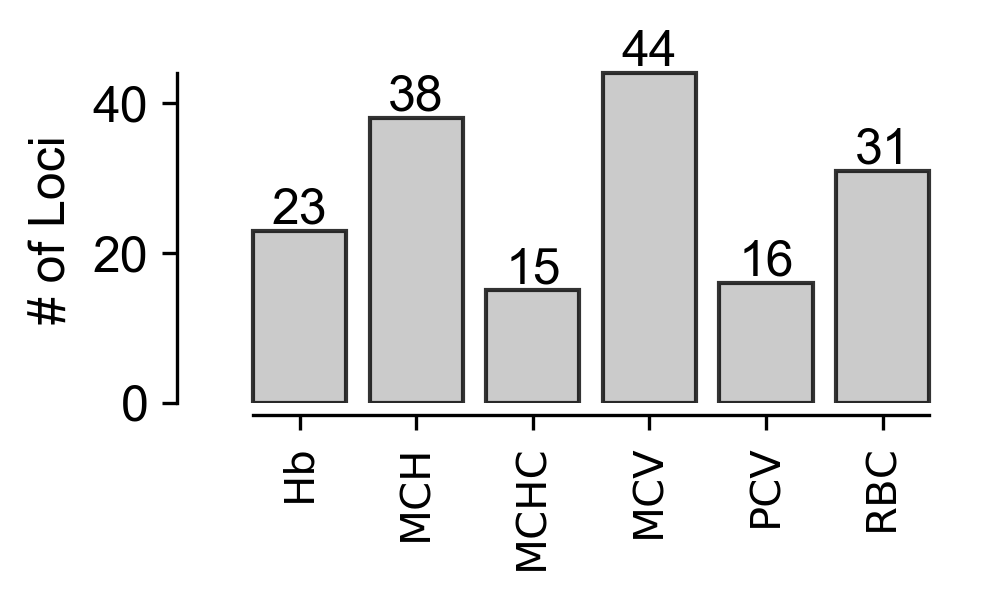

In [18]:
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

adjust_spines(ax, ['bottom', 'left'])

ax.bar(range(len(traitVals)), traitVals, fc='0.75', ec='black', alpha=0.8)
    
ax.set_xticks(range(len(traitVals)))

ax.set_ylabel('# of Loci', fontsize=12)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

for x in range(len(traitVals)):
    ax.text(x, traitVals[x]+1, traitVals[x], fontsize=12, ha='center', fontname='Arial')
    
ax.spines['bottom'].set_position(('outward', 3))
    
ax.set_xticklabels(traits, rotation=90)
    
plt.tight_layout(True)

## Size of SNP LD Blocks, distributions (S1B)

In [19]:
snpref['dist'] = snpref['blockEnd'].values - snpref['blockStart'].values + 1

bandwidth = 0.342652984684


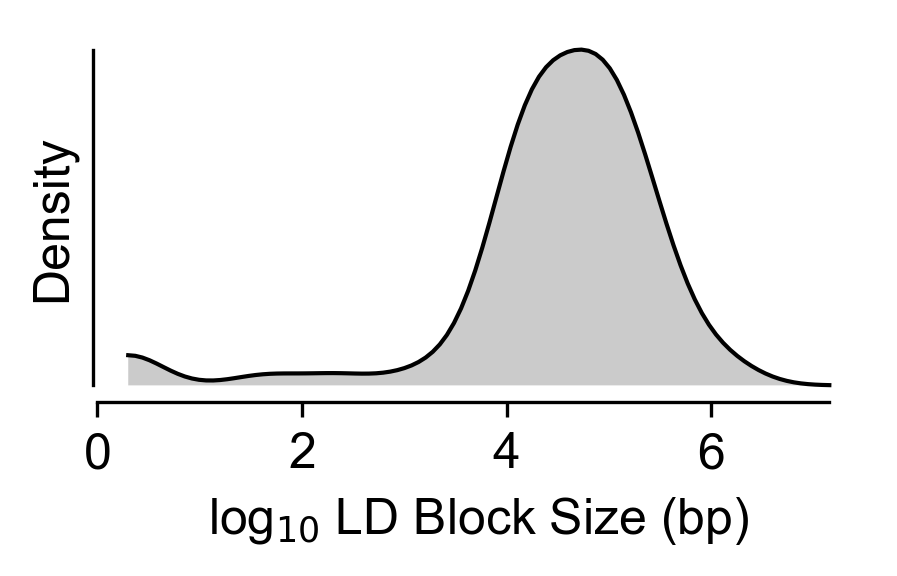

In [20]:
fig, ax = plt.subplots(1, dpi=300, figsize=(3.4,2))

dists = snpref['dist'].values
dists = np.log10(dists)
xVals = np.linspace(dists.min(), dists.max()+1, 100)
yVals = kdestimate(dists, xVals)

ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.8)
ax.plot(xVals, yVals, color='black', linewidth=1)

adjust_spines(ax, ['left', 'bottom'])

ax.spines['bottom'].set_position(('outward', 0))
ax.spines['bottom'].set_smart_bounds(True)

ax.spines['left'].set_position(('outward', 0))
ax.spines['left'].set_smart_bounds(True)

ax.set_ylabel('Density')

ax.set_xlabel('log' + r'$_{10}$' + ' LD Block Size (bp)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

plt.tight_layout(True)

ax.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,
    labelleft=False)

## Genes per Loci (S1C)

Text(18,10,'median = 4')

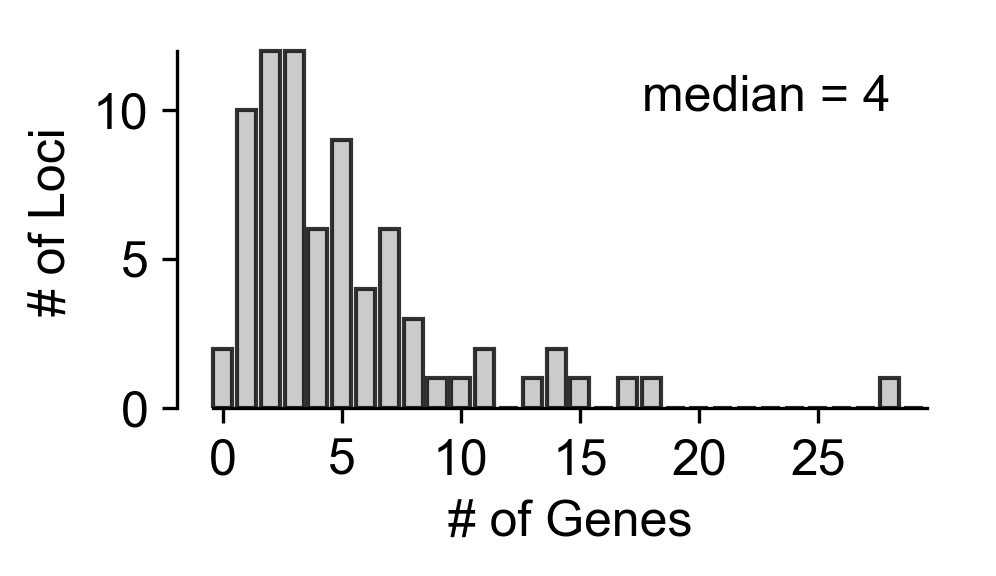

In [21]:
fig, ax = plt.subplots(1, dpi=300, figsize=(3.4, 2))
genesPerLoci = []

for snp in annoref['snp'].unique():
    genesPerLoci.append(len(annoref[annoref['snp'] == snp]))

genesPerLoci.append(0)

genesPerLoci = np.array(genesPerLoci)

ax.hist(genesPerLoci, bins=30, range=(0,30), width=0.8, fc='0.75', ec='black', alpha=0.8)

adjust_spines(ax, ['left', 'bottom'])

ax.spines['bottom'].set_position(('outward', 0))
ax.spines['bottom'].set_smart_bounds(True)

ax.spines['left'].set_position(('outward', 0))
ax.spines['left'].set_smart_bounds(True)

ax.set_xlabel('# of Genes')
ax.set_ylabel('# of Loci')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.set_xticks([0.4, 5.4, 10.4, 15.4, 20.4, 25.4])
ax.set_xticklabels(['0', '5', '10', '15', '20', '25'])

plt.tight_layout(True)

ax.text(18, 10, 'median = ' + str(int(np.median(genesPerLoci))), fontsize=12, fontname='Arial')

## Number of hairpins per gene (S1D)

In [22]:
hairpins = []
for gene in annoref[annoref['anno'] == 'gwa']['gene'].values:
    hairpins.append(shref[shref['gene'] == gene].shape[0])

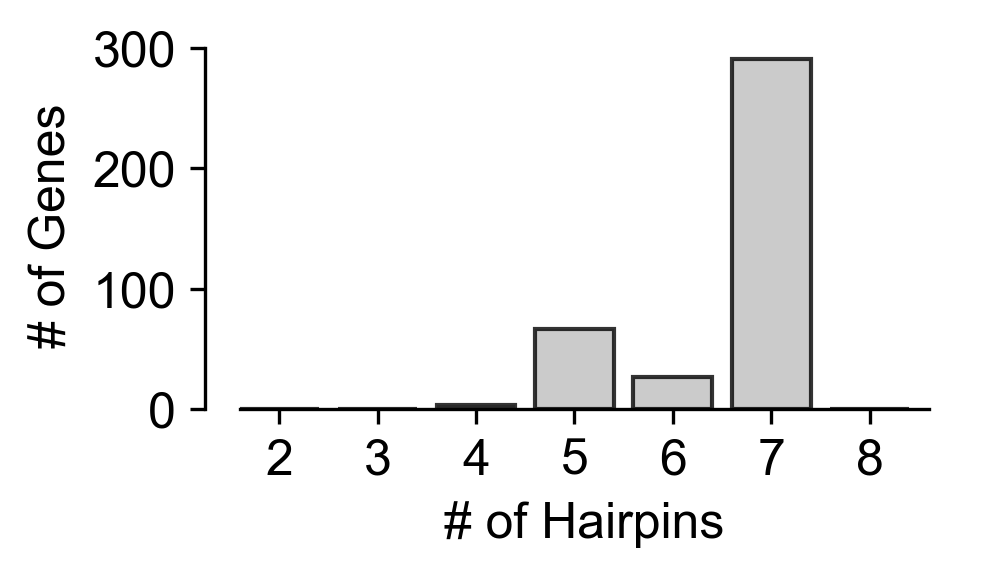

In [23]:
fig, ax = plt.subplots(1, dpi=300, figsize=(3.4,2))
    
ax.hist(hairpins, bins=7, range=(2,9), width=0.8, fc='0.75', ec='black', alpha=0.8)

adjust_spines(ax, ['left', 'bottom'])

ax.spines['bottom'].set_position(('outward', 0))
ax.spines['bottom'].set_smart_bounds(True)

ax.spines['left'].set_position(('outward', 0))
ax.spines['left'].set_smart_bounds(True)

ax.set_xlabel('# of Hairpins')
ax.set_ylabel('# of Genes')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    #item.set_fontname('Arial')
    item.set_fontname('Arial')

ax.set_xticks([0.4+x for x in range(2,9)])
ax.set_xticklabels([str(x) for x in range(2,9)])

plt.tight_layout(True)

## Log2 fold counts across screen at d0 (2A)

bandwidth = 0.183832053199


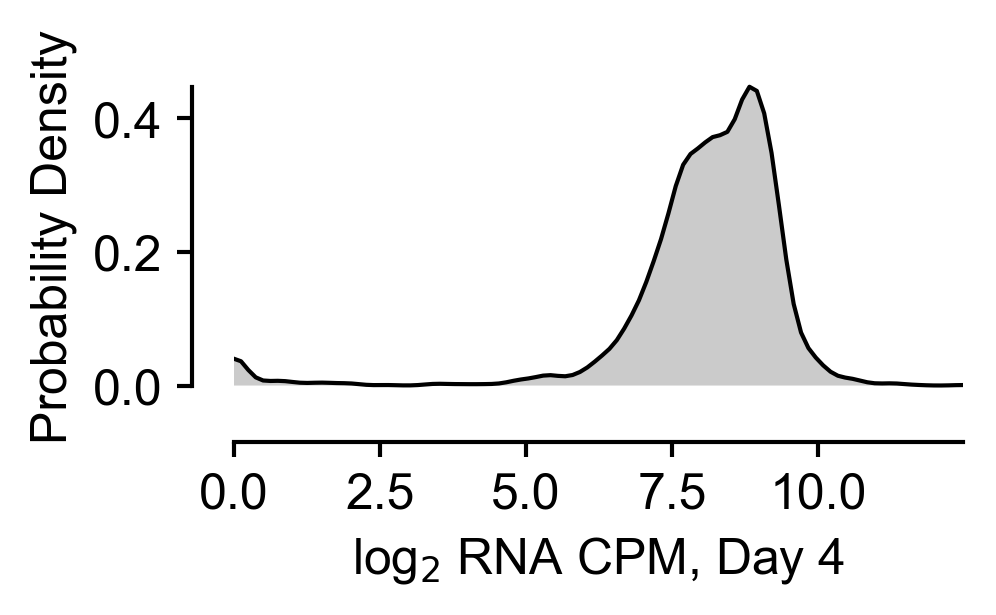

In [24]:
fig, ax = plt.subplots(1, dpi=300, figsize=(3.4, 2))

yRaw = phenoRaw[[x for x in phenoRaw.columns if 'd4' in x]].mean(axis=1).values
xVals = np.linspace(yRaw.min(), yRaw.max(), 100)

yVals = kdestimate(yRaw, xVals)

ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.8)
ax.plot(xVals, yVals, color='black', linewidth=1)
ax.set_xlim(xVals[0], xVals[-1])

ax.tick_params(
    axis='y',
    which='both',
    left=True,
    right=False,
    labelleft=True)

ax.tick_params(
    axis='x',
    which='both',
    top=False,
    bottom=True,
    labelbottom=True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_ylabel('Probability Density')
ax.set_xlabel('log' + r'$_2$' + ' RNA CPM, Day 4')

adjust_spines(ax, ['bottom', 'left'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
plt.tight_layout(True)

## Fold change plots D4 - DX (2B, S2A)

In [25]:
genes = pheno['gene'].unique()

In [26]:
phenoMean = []
phenoStd = []

for gene in genes:
    vals = pheno[(pheno['gene'] == gene)][[x for x in pheno.columns if 'd16' in x]].mean().values
    phenoMean.append(vals.mean())
    phenoStd.append(vals.std())

phenoMean = np.array(phenoMean)
phenoStd = np.array(phenoStd)

print(len(genes), phenoMean.shape, phenoStd.shape)

419 (419,) (419,)


In [27]:
sortInds = np.argsort(phenoMean)

phenoMean = phenoMean[sortInds]
phenoStd = phenoStd[sortInds]
genes = np.array(genes)[sortInds]

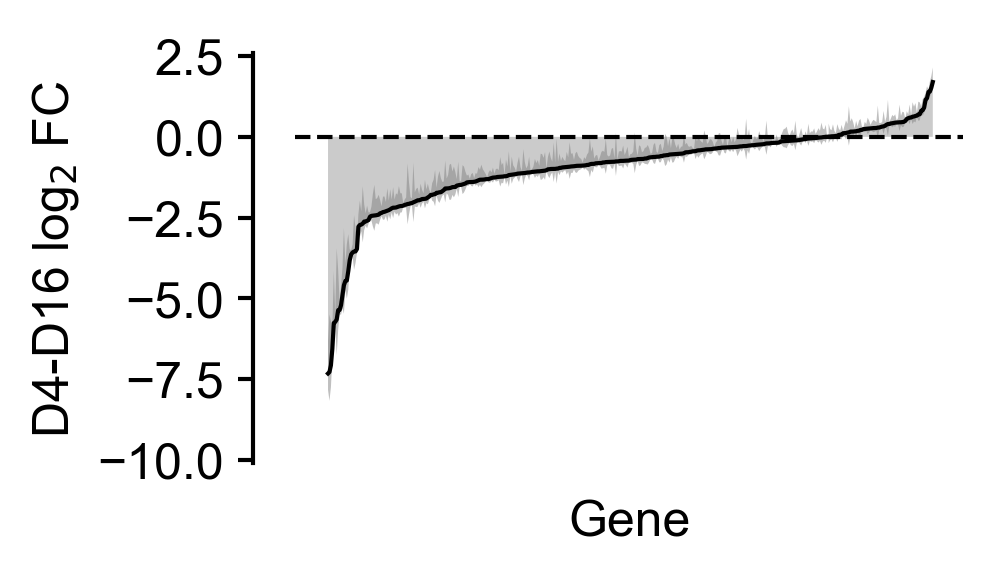

In [28]:
fig, ax = plt.subplots(1, dpi=300, figsize=(3.4,2))

# Plot the means.
#ax.plot(range(len(phenoMean[phenoMean <= 0])), phenoMean[phenoMean <= 0], color='red')
ax.fill_between(range(len(phenoMean[phenoMean <= 0])), phenoMean[phenoMean <= 0], facecolor='0.75', alpha=0.8)
#ax.plot(range(len(phenoMean[phenoMean <= 0]), len(phenoMean[phenoMean <= 0])+len(phenoMean[phenoMean > 0])), phenoMean[phenoMean > 0], color='blue')
ax.fill_between(range(len(phenoMean[phenoMean <= 0]), len(phenoMean[phenoMean <= 0])+len(phenoMean[phenoMean > 0])), phenoMean[phenoMean > 0], facecolor='0.75', alpha=0.8)

# Plot the 2 std's.
ax.fill_between(range(len(phenoMean[phenoMean <= 0])), phenoMean[phenoMean <= 0] - phenoStd[phenoMean <= 0], phenoMean[phenoMean <= 0] + 2*phenoStd[phenoMean <= 0], facecolor='0.5', alpha=0.5)
ax.fill_between(range(len(phenoMean[phenoMean <= 0]), len(phenoMean[phenoMean <= 0])+len(phenoMean[phenoMean > 0])), phenoMean[phenoMean > 0] - phenoStd[phenoMean > 0], phenoMean[phenoMean > 0] + 2*phenoStd[phenoMean > 0], facecolor='0.5', alpha=0.5)

ax.plot(range(len(phenoMean)), phenoMean, color='black', linewidth=1)

ax.axhline(0, color='black', ls='dashed', lw=1)

ax.set_ylabel('D4-D16 log' + r'$_2$' + ' FC')
ax.set_xlabel('Gene')

adjust_spines(ax, ['left'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

ax.set_yticks([-10, -7.5, -5.0, -2.5, 0, 2.5])
ax.scatter([0,0], [-10, 2.5], color='white')

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
plt.tight_layout(True)

In [29]:
print('RPS19', phenoMean[list(genes).index('RPS19')],
      '\nGATA1', phenoMean[list(genes).index('GATA1')],
      '\nLuc', phenoMean[list(genes).index('promegaLuc')],
      '\nLuc', phenoMean[list(genes).index('promegaLuc.1')],
      '\nLacZ', phenoMean[list(genes).index('lacZ')])

RPS19 -4.44418636163 
GATA1 -3.63486739223 
Luc 0.213669955346 
Luc 0.554316885078 
LacZ 0.64610625704


In [30]:
ymin, ymax = ax.get_ylim()

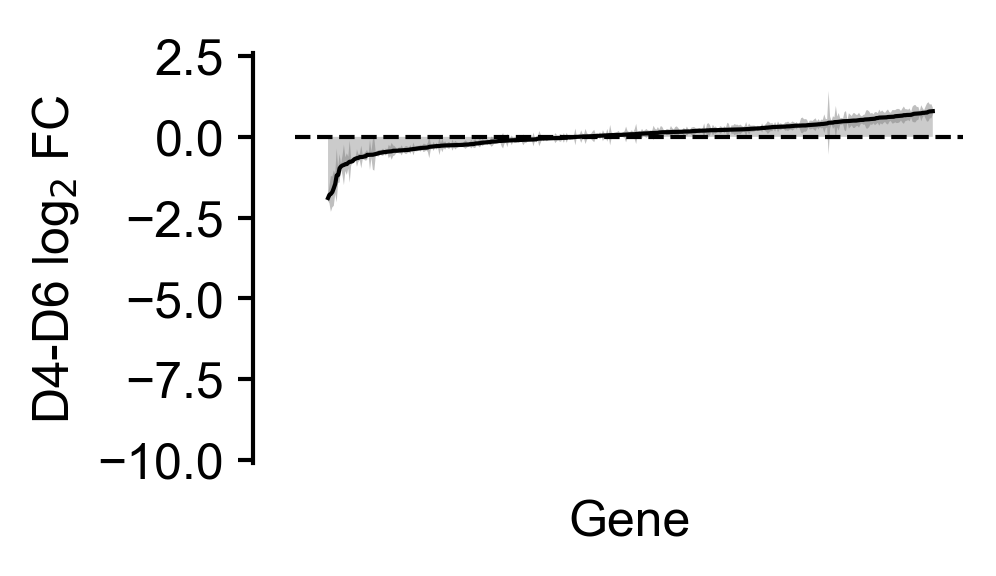

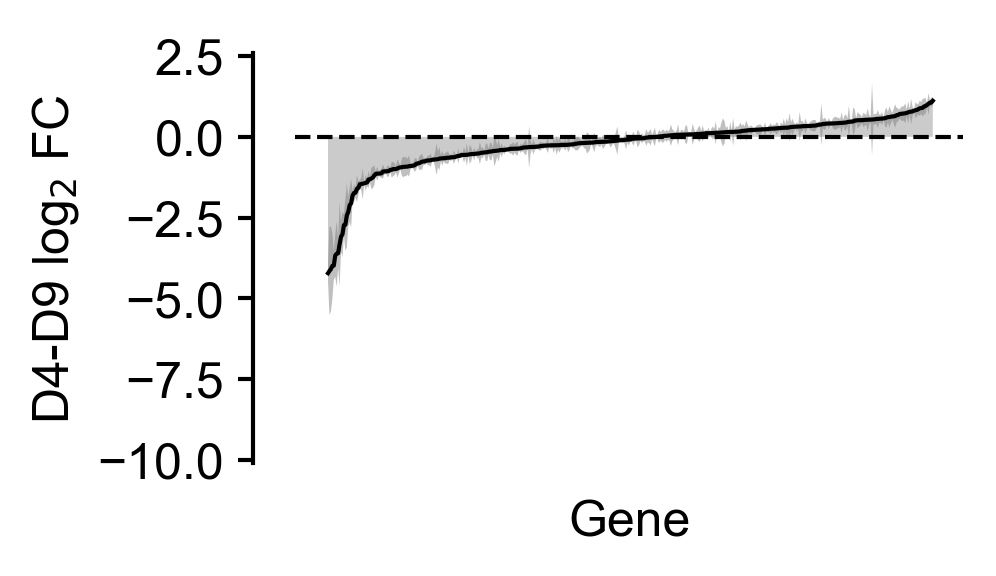

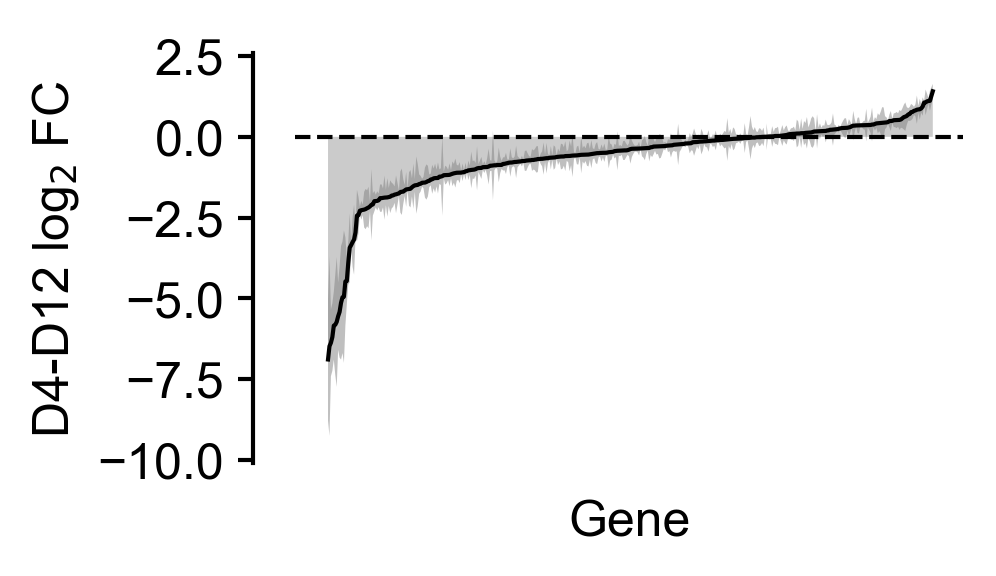

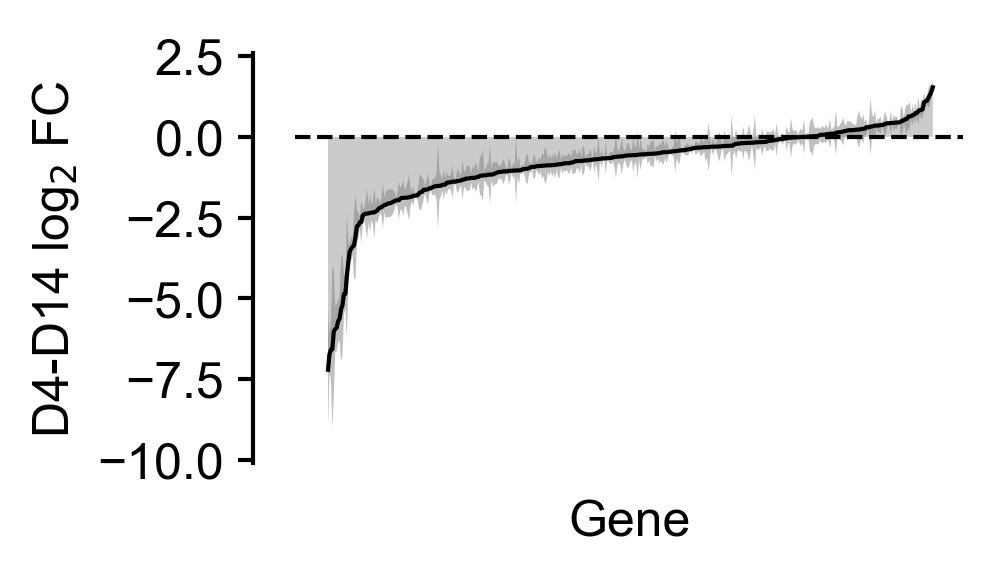

In [31]:
genes = list(phenoRaw['gene'].unique())

for day in ['d6', 'd9', 'd12', 'd14']:

    phenoMean = []
    phenoStd = []

    for gene in genes:
        vals = pheno[(pheno['gene'] == gene)][[x for x in pheno.columns if day in x]].mean().values
        phenoMean.append(vals.mean())
        phenoStd.append(vals.std())

    phenoMean = np.array(phenoMean)
    phenoStd = np.array(phenoStd)

    sortInds = np.argsort(phenoMean)

    phenoMean = phenoMean[sortInds]
    phenoStd = phenoStd[sortInds]
    genes = np.array(genes)[sortInds]

    fig, ax = plt.subplots(1, dpi=300, figsize=(3.4,2))

    ax.set_ylim([ymin, ymax])
    
    # Plot the means.
    ax.fill_between(range(len(phenoMean[phenoMean <= 0])), phenoMean[phenoMean <= 0], facecolor='0.75', alpha=0.8)
    ax.fill_between(range(len(phenoMean[phenoMean <= 0]), len(phenoMean[phenoMean <= 0])+len(phenoMean[phenoMean > 0])), phenoMean[phenoMean > 0], facecolor='0.75', alpha=0.8)

    # Plot the 2 std's.
    ax.fill_between(range(len(phenoMean[phenoMean <= 0])), phenoMean[phenoMean <= 0] - 2*phenoStd[phenoMean <= 0], phenoMean[phenoMean <= 0] + 2*phenoStd[phenoMean <= 0], facecolor='0.5', alpha=0.5)
    ax.fill_between(range(len(phenoMean[phenoMean <= 0]), len(phenoMean[phenoMean <= 0])+len(phenoMean[phenoMean > 0])), phenoMean[phenoMean > 0] - 2*phenoStd[phenoMean > 0], phenoMean[phenoMean > 0] + 2*phenoStd[phenoMean > 0], facecolor='0.5', alpha=0.5)

    ax.plot(range(len(phenoMean)), phenoMean, color='black', linewidth=1)
    ax.scatter([0,0], [-10, 2.5], color='white')
    
    ax.axhline(0, color='black', ls='dashed', lw=1)

    ax.set_ylabel('D4-D' + day[1:] + ' log' + r'$_2$' + ' FC')
    ax.set_xlabel('Gene')

    ax.set_yticks([-10, -7.5, -5.0, -2.5, 0, 2.5])
    
    adjust_spines(ax, ['left'])

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
        item.set_fontname('Arial')

    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=1)

    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)

    plt.tight_layout(True)

## Replicate Correlation (S2B)

In [32]:
from scipy.stats import pearsonr

In [33]:
phenoRaw.head()

,id,shrna,seed,type,gene,chr,gWindowStart,gWindowEnd,snp,snpPos,...,pheno-r2d9,pheno-r2d12,pheno-r2d14,pheno-r2d16,pheno-r3d4,pheno-r3d6,pheno-r3d9,pheno-r3d12,pheno-r3d14,pheno-r3d16
0,sr0001,GCCAGCACTATACCATTGTT,AACAATG,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,8.168618,7.216856,6.431004,6.854079,9.272318,9.080030,8.437203,7.973226,7.506765,7.469177
1,sr0002,CCGGACTATCTGCATAGCTT,AAGCTAT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,5.696405,4.695998,4.356206,4.794245,5.269092,5.935881,4.659593,4.457044,3.846062,4.992486
2,sr0003,CCTGATTCTATACTTTGTGA,TCACAAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,6.255011,5.573350,5.240208,5.389931,5.584000,5.970930,5.819766,6.374147,5.863295,5.264574
3,sr0004,GCTGAGATTGTGGTTGGTGA,TCACCAA,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,7.874147,7.334211,6.416454,7.007362,9.355140,8.514990,7.520692,7.533141,6.873735,7.141803
4,sr0005,GATGCACTGACCCAGATTAA,TTAATCT,gwa,ATP2B4,chr1,203485914.0,203753209.0,rs7551442,203655121.0,...,6.129638,5.452987,4.988071,4.707398,8.551055,7.280156,5.887062,3.842022,5.244593,5.370776


In [34]:
pheno1 = phenoRaw[[x for x in phenoRaw.columns if 'r1' in x]].values.flatten()
pheno2 = phenoRaw[[x for x in phenoRaw.columns if 'r2' in x]].values.flatten()
pheno3 = phenoRaw[[x for x in phenoRaw.columns if 'r3' in x]].values.flatten()

pheno1 = phenoRaw[[x for x in phenoRaw.columns if 'r1d4' in x]].values.flatten() - phenoRaw[[x for x in phenoRaw.columns if 'r1d16' in x]].values.flatten()
pheno2 = phenoRaw[[x for x in phenoRaw.columns if 'r2d4' in x]].values.flatten() - phenoRaw[[x for x in phenoRaw.columns if 'r2d16' in x]].values.flatten()
pheno3 = phenoRaw[[x for x in phenoRaw.columns if 'r3d4' in x]].values.flatten() - phenoRaw[[x for x in phenoRaw.columns if 'r3d16' in x]].values.flatten()

***Pheno1, Pheno2***

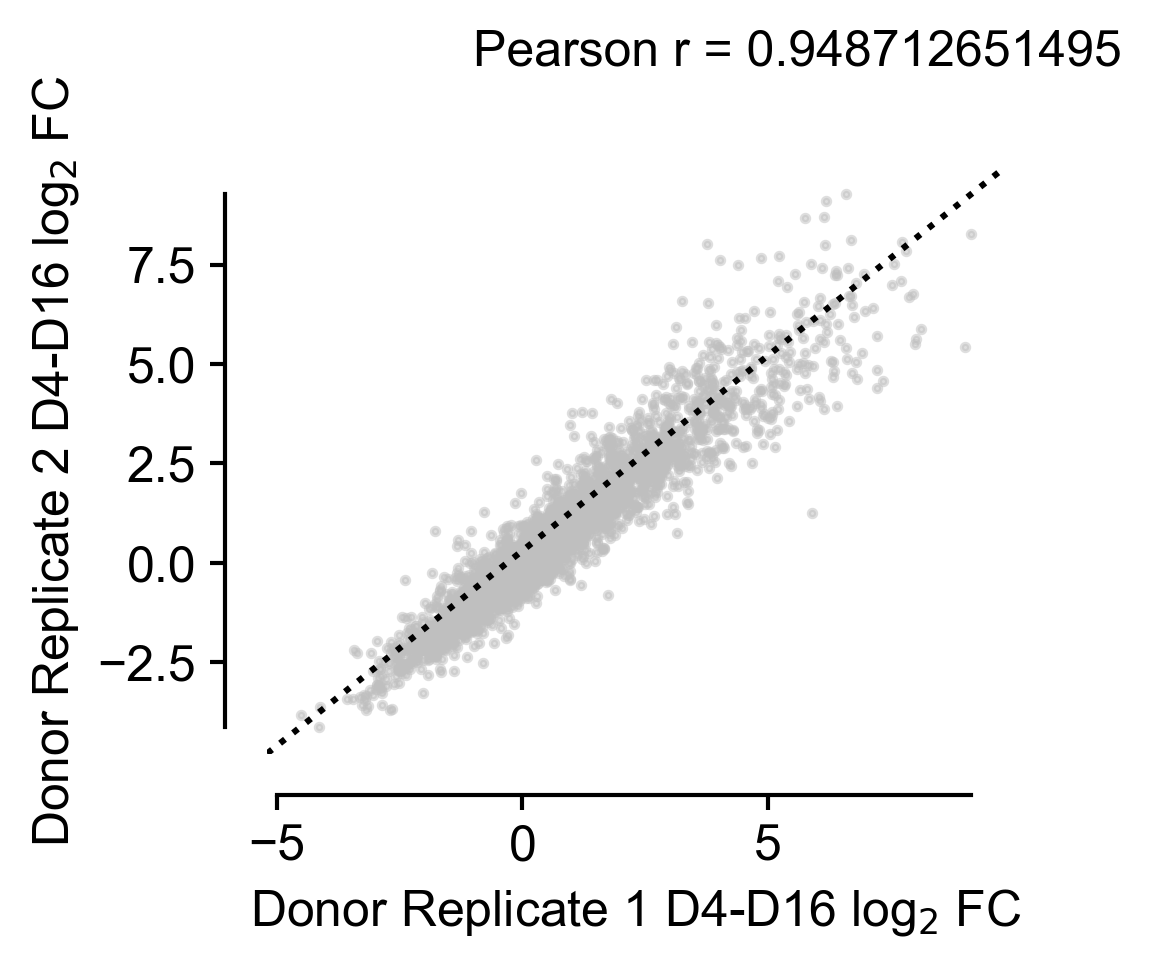

In [35]:
fig, ax = plt.subplots(1, figsize=(3.4,3), dpi=300)

ax.scatter(pheno1, pheno2, color='0.75', alpha=0.5, s=3)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', ls='dotted')

ax.set_xlabel('Donor Replicate 1 D4-D16 log' r'$_2$' + ' FC')
ax.set_ylabel('Donor Replicate 2 D4-D16 log' r'$_2$' + ' FC')

ax.text(-1.0,12.5,'Pearson r = ' + str(pearsonr(pheno1, pheno2)[0]), size=12, fontname='Arial')

adjust_spines(ax, ['bottom', 'left'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
plt.tight_layout(True)

***Pheno1, Pheno3***

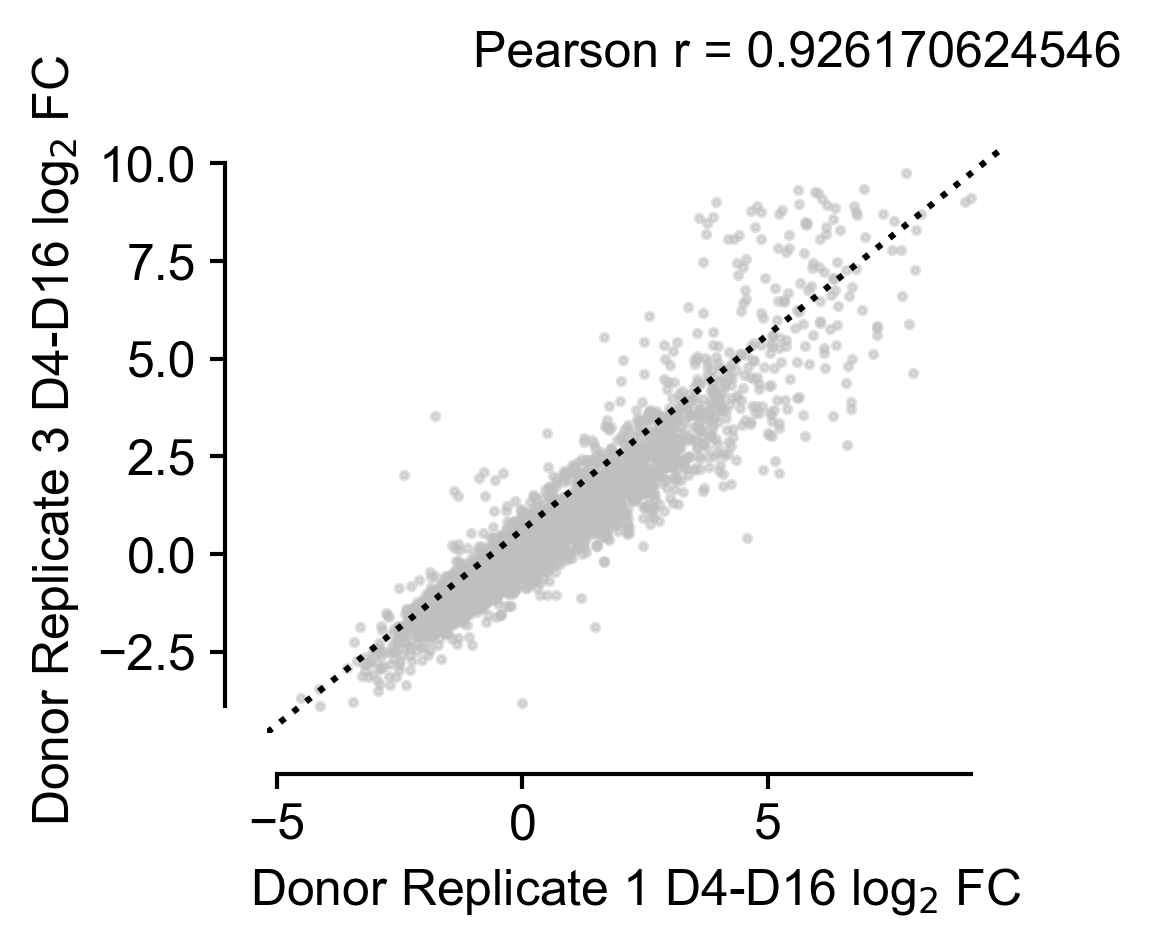

In [36]:
fig, ax = plt.subplots(1, figsize=(3.4,3), dpi=300)

ax.scatter(pheno1, pheno3, color='0.75', alpha=0.5, s=3)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', ls='dotted')

ax.set_xlabel('Donor Replicate 1 D4-D16 log' r'$_2$' + ' FC')
ax.set_ylabel('Donor Replicate 3 D4-D16 log' r'$_2$' + ' FC')

ax.text(-1.0,12.5,'Pearson r = ' + str(pearsonr(pheno1, pheno3)[0]), size=12, fontname='Arial')

adjust_spines(ax, ['bottom', 'left'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
plt.tight_layout(True)

***Pheno2, Pheno3***

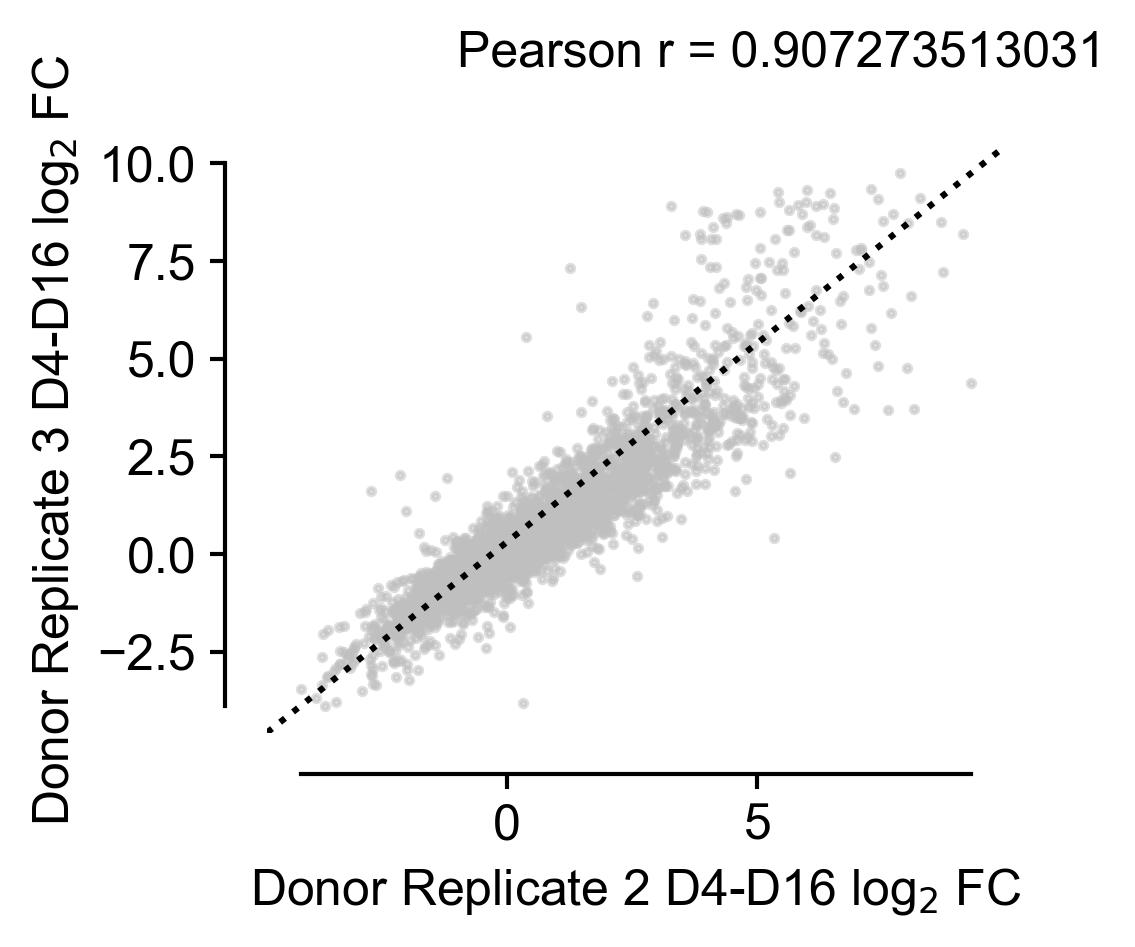

In [37]:
fig, ax = plt.subplots(1, figsize=(3.4,3), dpi=300)

ax.scatter(pheno2, pheno3, color='0.75', alpha=0.5, s=3)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', ls='dotted')

ax.set_xlabel('Donor Replicate 2 D4-D16 log' r'$_2$' + ' FC')
ax.set_ylabel('Donor Replicate 3 D4-D16 log' r'$_2$' + ' FC')

ax.text(-1.0,12.5,'Pearson r = ' + str(pearsonr(pheno2, pheno3)[0]), size=12, fontname='Arial')

adjust_spines(ax, ['bottom', 'left'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
plt.tight_layout(True)

## +/- Examples (2D)

In [38]:
chosenGenes = ['GATA1', 'RPS19', 'lacZ', 'promegaLuc', 'RUNDC3A', 'EIF5']
chosenGeneNames = ['GATA1', 'RPS19', 'LacZ', 'Luciferase', 'RUNDC3A', 'EIF5']

In [39]:
d4vals = []
for gene in chosenGenes:
    d4vals.append(phenoRaw[phenoRaw['gene'] == gene][[x for x in phenoRaw.columns if 'd4' in x]].values.flatten())

In [40]:
d16vals = []
for gene in chosenGenes:
    d16vals.append(phenoRaw[phenoRaw['gene'] == gene][[x for x in phenoRaw.columns if 'd16' in x]].values.flatten())

To further customize violin plot, see:
https://matplotlib.org/devdocs/gallery/statistics/customized_violin.html

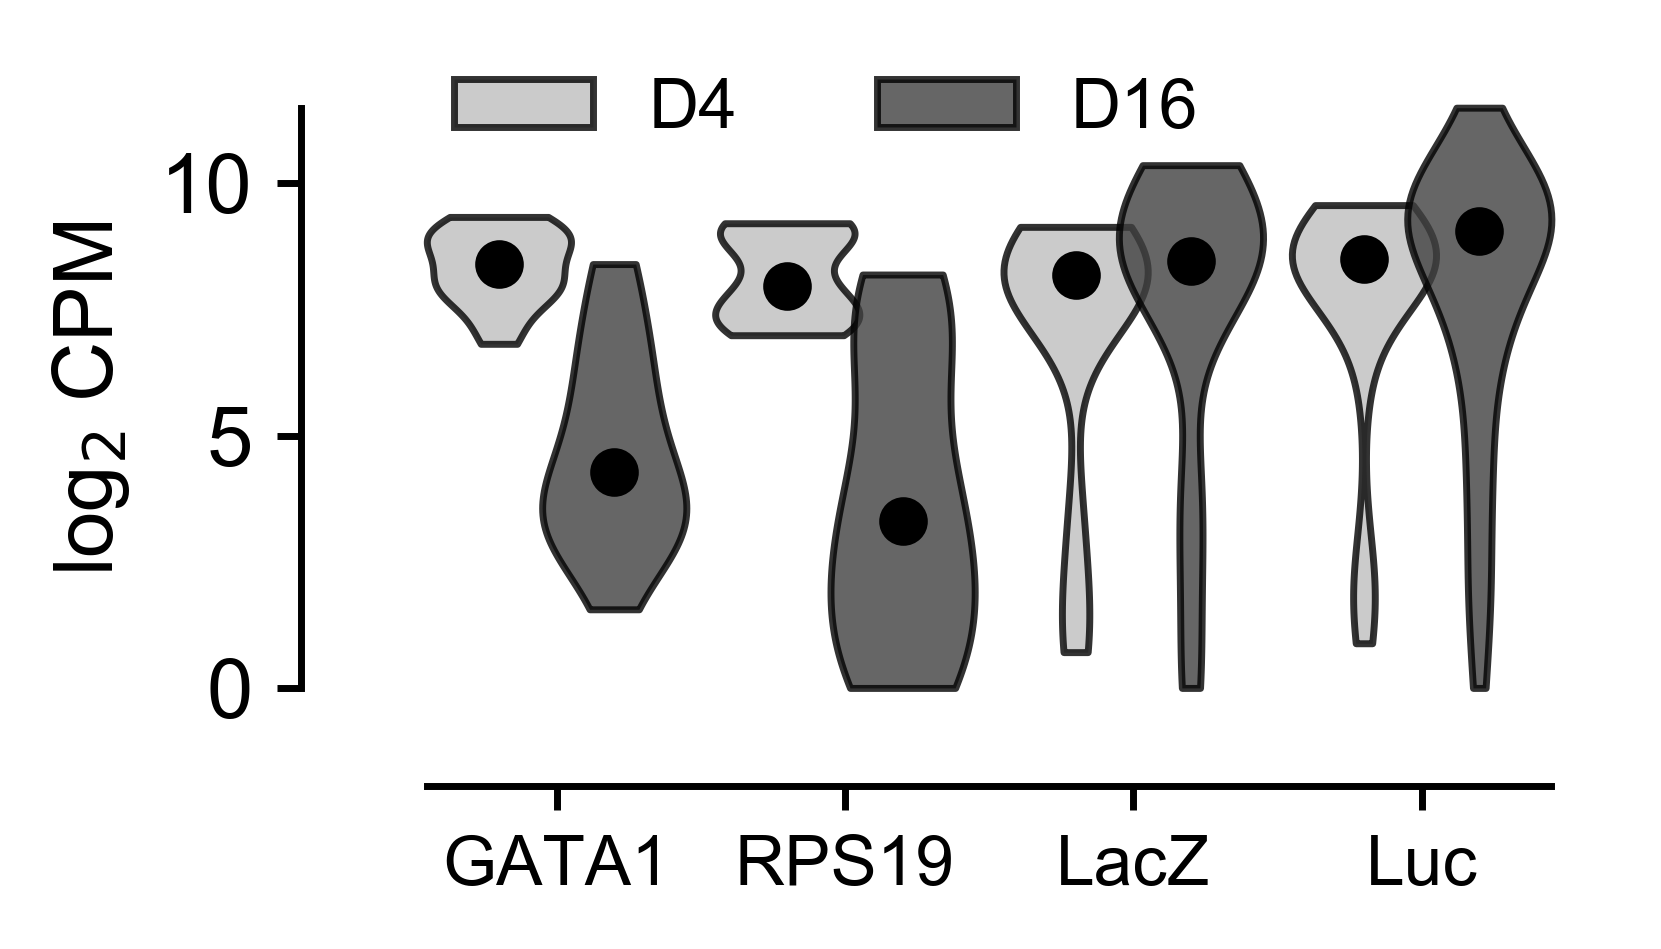

In [41]:
genesForPlot = 4

import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, dpi=500, figsize=(3.4,2))

d4boxes = ax.violinplot(d4vals[:genesForPlot], positions=np.linspace(0.8, genesForPlot-0.2, genesForPlot), showmeans=False, showmedians=False,
        showextrema=False)
d16boxes = ax.violinplot(d16vals[:genesForPlot], positions=np.linspace(1.2, genesForPlot+0.2, genesForPlot), showmeans=False, showmedians=False,
        showextrema=False)

adjust_spines(ax, ['bottom', 'left'])

ax.set_xticks(range(1,5))
ax.set_xticklabels(['GATA1', 'RPS19', 'LacZ', 'Luc'])

for box in d4boxes['bodies']:
    box.set_facecolor('0.75')
    box.set_edgecolor('black')
    box.set_alpha(0.8)
    
for box in d16boxes['bodies']:
    box.set_facecolor('0.25')
    box.set_edgecolor('black')
    box.set_alpha(0.8)
    
ax.set_ylabel('log' r'$_2$' + ' CPM')

ax.scatter(np.linspace(0.8, genesForPlot-0.2, genesForPlot), [np.median(x) for x in d4vals[:genesForPlot]], color='black')
ax.scatter(np.linspace(1.2, genesForPlot+0.2, genesForPlot), [np.median(x) for x in d16vals[:genesForPlot]], color='black')

b = mpatches.Patch(facecolor='0.75', alpha=0.8, linewidth=1, edgecolor='black')
r = mpatches.Patch(facecolor='0.25', alpha=0.8, linewidth=1, edgecolor='black')


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')
    
for item in (ax.get_xticklabels()):
    item.set_fontsize(10)
    item.set_fontname('Arial')
    
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

font = mpl.font_manager.FontProperties(family='Arial')
    
ax.legend((b,r), ('D4', 'D16'), ncol=2, bbox_to_anchor=(0.72, 1.1), fontsize=10, prop=font, frameon=False)

plt.tight_layout(True)

   ## Log2 FC Comparison by Type (2C, 2E)

In [42]:
types = list(annoref['anno'].unique())
colors = ['green', 'red', 'orange', 'blue']
labels = ['GWAS-nominated', 'Erythroid', 'Essential', '- Control']
print(types)
print(labels)

['gwa', 'ery', 'ess', 'neg']
['GWAS-nominated', 'Erythroid', 'Essential', '- Control']


In [43]:
fcs = []
for typ in types:
    fcs.append((phenoRaw[phenoRaw['type'] == typ][[x for x in phenoRaw.columns if 'd16' in x]].values - \
    phenoRaw[phenoRaw['type'] == typ][[x for x in phenoRaw.columns if 'd4' in x]].values).mean(axis=1))

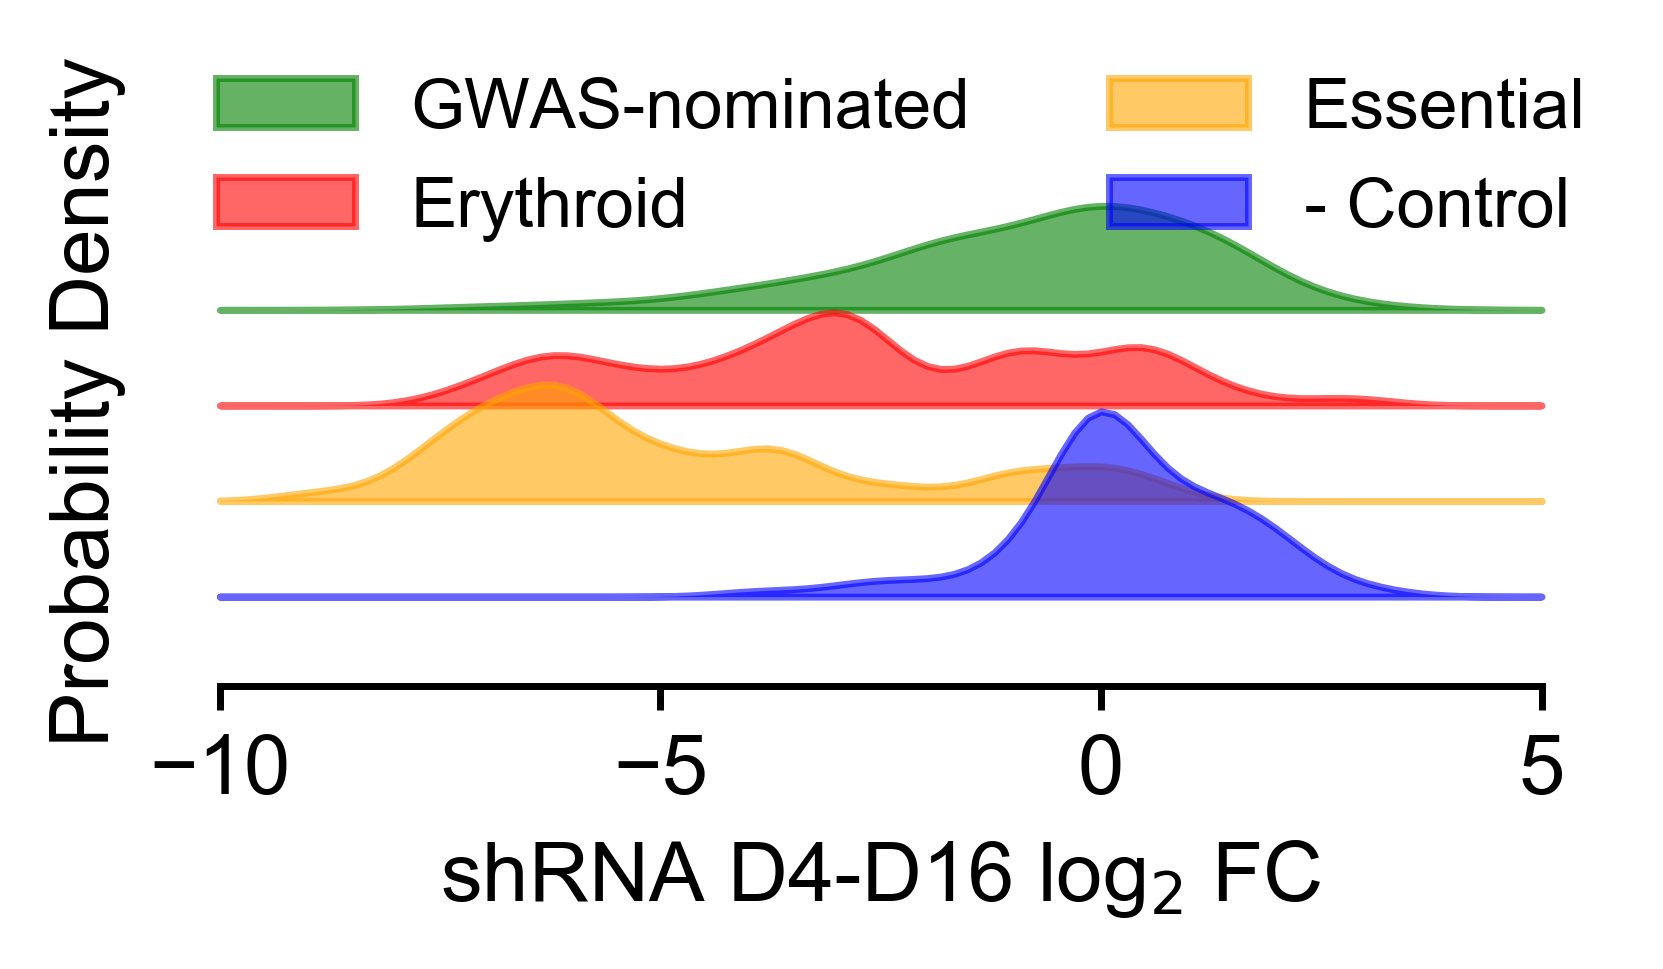

In [44]:
fig, ax = plt.subplots(1, dpi=500, figsize=(3.4,2))

xVals = np.linspace(-10, 5, 100)

for i,typ in enumerate(types):
    fc = fcs[i]
    
    ax.fill_between(xVals, 0-i*0.2, kdestimate(fc, xVals, bandwidth=0.5)-i*0.2, color=colors[i], alpha=0.6, label=labels[i])
    
ax.set_ylabel('Probability Density')
ax.set_xlabel('shRNA D4-D16 log' + r'$_2$' + ' FC')

adjust_spines(ax, ['bottom'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
lgd = ax.legend(ncol=2, frameon=False, fontsize=10, loc='upper left', prop=font, bbox_to_anchor=(0.0,1.4))

plt.tight_layout(False)

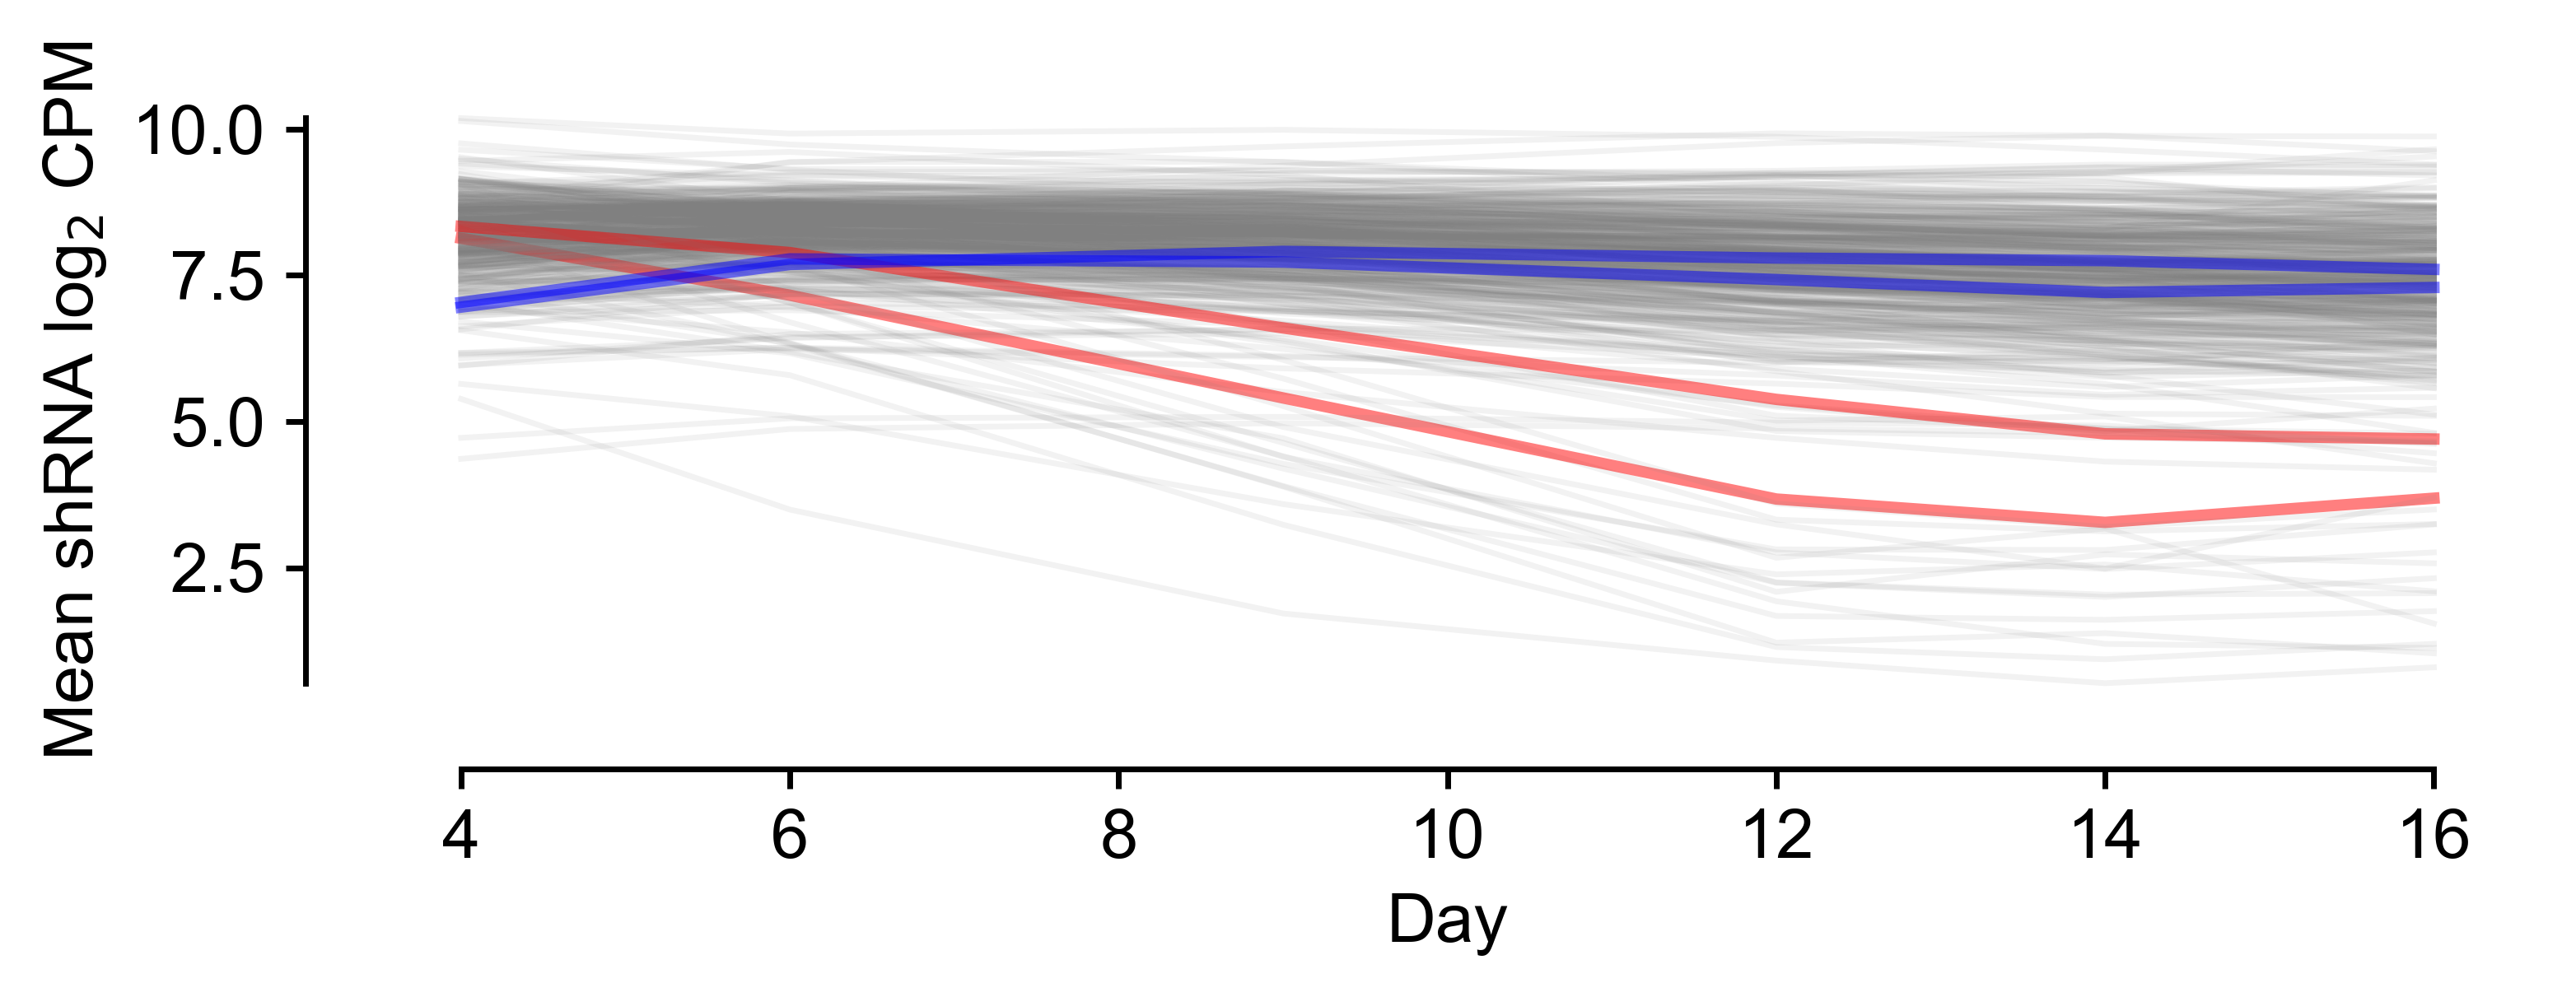

In [45]:
genes = pheno['gene'].unique()

fig, ax = plt.subplots(1, dpi=500, figsize=(6.8,2))

ax.set_ylabel('Mean shRNA log' + r'$_2$' + ' CPM')
ax.set_xlabel('Day')

adjust_spines(ax, ['bottom', 'left'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
for gene in genes:
    vals = phenoRaw[phenoRaw['gene'] == gene][[x for x in phenoRaw.columns if 'pheno-r' in x]].values
    vals = vals.reshape(vals.shape[0]*3,6)
    vals = vals.mean(axis=0)
    if vals.mean() != 0:
        if gene in ['GATA1', 'RPS19']:
            ax.plot([4, 6, 9, 12, 14, 16], vals, color='red', linewidth=2, alpha=0.5)
        elif gene in ['lacZ']:
            ax.plot([4, 6, 9, 12, 14, 16], vals, color='blue', linewidth=2, alpha=0.5)
        elif gene in ['promegaLuc']:
            vals = phenoRaw[phenoRaw['gene'].isin(['promegaLuc', 'promegaLuc.1'])][[x for x in phenoRaw.columns if 'pheno-r' in x]].values
            vals = vals.reshape(vals.shape[0]*3,6)
            vals = vals.mean(axis=0)
            ax.plot([4, 6, 9, 12, 14, 16], vals, color='blue', linewidth=2, alpha=0.5)
        elif gene in ['promegaLuc.1']:
            pass
        else:
            ax.plot([4, 6, 9, 12, 14, 16], vals, color='gray', linewidth=1, alpha=0.1)

# Linear Mixed Model (LMM)

Implemented in R, script below:
```
library(Matrix)
library(lme4)
library(dplyr)
library(readr)
library(optimx)
library(qvalue)
library(car)
df <- read_csv("ref/rInput/allInput.csv")
df <- as.data.frame(df)
df$day <- as.factor(df$day)

# Need to get rid of genes with < 3 hairpins or all 0 reads for lme to work.
goodGenes <- df %>%
  group_by(geneName) %>%
  summarize(count=n(), Mean=mean(l2Vals)) %>%
  filter(count >= 54, Mean > 0.0) %>%
  .$geneName
  
optimizer <- lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb'))

mm <- df %>%
  filter(geneName %in% goodGenes) %>%
  group_by(geneName) %>%
  do(
      tempMod = lmer(l2Rel4 ~ 1 + totalDur + (0 + totalDur|shrnaName), data=., control=optimizer, REML=FALSE)
    ) %>%
    do(
      gene = .$geneName,
      intercept = .$tempMod@beta[1],
      betaDur = .$tempMod@beta[2],
      pval = Anova(.$tempMod)$Pr[1]
  )

mm$gene = unlist(mm$gene)
mm$intercept = unlist(mm$intercept)
mm$betaDur = unlist(mm$betaDur)
mm$pval = unlist(mm$pval)
mm$qval <- qvalue(mm$pval)$qvalues

write.csv(mm, file='rModelOutput.csv')
```

# LMM Results Analysis

## Hits per SNP (3A)

In [46]:
modeldf = pd.read_csv('ref/rModelOutput.csv')
modeldf.head()

,gene,intercept,betaDur,pval,qval,type,snp
0,ABCF1,0.352097,-0.051540,0.363531,0.306232,gwa,rs2097775
1,ABO,0.349261,-0.025273,0.462122,0.353532,gwa,rs579459
2,ACAD10,0.123335,-0.062494,0.354127,0.305168,gwa,rs3184504
3,ACADS,0.041335,-0.086487,0.109041,0.150501,gwa,rs3829290
4,ACD,0.403892,0.043773,0.293867,0.267592,gwa,rs2271294


In [47]:
modeldf[modeldf['gene'].isin(shref[shref['snp'] == 'rs2159213']['gene'].unique())]

,gene,intercept,betaDur,pval,qval,type,snp
15,AMH,0.032646,0.068726,0.237781,0.238753,gwa,rs2159213
19,AP3D1,0.032876,-0.082098,0.086974,0.133986,gwa,rs2159213
99,DOT1L,0.120601,0.061021,0.073185,0.122516,gwa,rs2159213
161,IZUMO4,0.400836,-0.052894,0.297726,0.269720,gwa,rs2159213
187,MKNK2,0.278652,-0.044889,0.493044,0.362397,gwa,rs2159213
189,MOB3A,0.012185,-0.102658,0.130925,0.168058,gwa,rs2159213
310,SF3A2,0.151142,-0.236992,0.000923,0.005764,gwa,rs2159213


In [48]:
snpLookup = annoref.set_index('gene').to_dict()['snp']

In [49]:
modeldf['snp'] = [snpLookup[x] for x in modeldf['gene'].values]

In [50]:
# Get all the gwa nominated genes that have a q value < 0.1 and beta magnitude > 0.1.
hitsDF = modeldf[(modeldf['qval'] < 0.1) & (abs(modeldf['betaDur'].values) > 0.1) & ([annoref.set_index('gene').to_dict()['anno'][x] == 'gwa' for x in modeldf['gene'].values])].copy()

In [51]:
#hitsDF = modeldf[modeldf['isHit0.1'] == True].copy()
print(hitsDF.shape)

(77, 7)


In [52]:
# Get total list of SNPs from hitsDF
snpHits = list(hitsDF['snp'].unique())
snpHits = [x for x in snpHits if type(x) == str]

len(snpHits)

38

In [53]:
geneHits = list(hitsDF['gene'].unique())
len(geneHits)

77

In [54]:
hitCounts = {}

for snp in snpHits:
    count = len(list(hitsDF[hitsDF['snp'] == snp]['gene'].unique()))
    hitCounts[snp] = count

In [55]:
# Count hits per snp per day for each SNP.
forPlot = []
forPlotPos = []
forPlotNeg = []

for i,snp in enumerate(snpHits):
    forPlot.append([snp])
    forPlotPos.append([snp])
    forPlotNeg.append([snp])
    forPlot[i].append([x for x in hitsDF['snp'].values].count(snp))
    forPlotPos[i].append([x for x in hitsDF[hitsDF['betaDur'] > 0]['snp'].values].count(snp))
    forPlotNeg[i].append([x for x in hitsDF[hitsDF['betaDur'] < 0]['snp'].values].count(snp))

In [56]:
# Sort values in ascending order
forPlot = sorted(forPlot, key = lambda x: (x[1], x[1], np.argmax(np.array(x[1]) > 0)))

In [57]:
newPos = []
for x in forPlot:
    for y in forPlotPos:
        if y[0] == x[0]:
            newPos.append(y)
        
newNeg = []
for x in forPlot:
    for y in forPlotNeg:
        if y[0] == x[0]:
            newNeg.append(y)
            
forPlotPos = newPos
forPlotNeg = newNeg

In [58]:
# Modified adjust spines for this figure
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')
        if loc == 'left':
            spine.set_position(('outward', -5))

    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

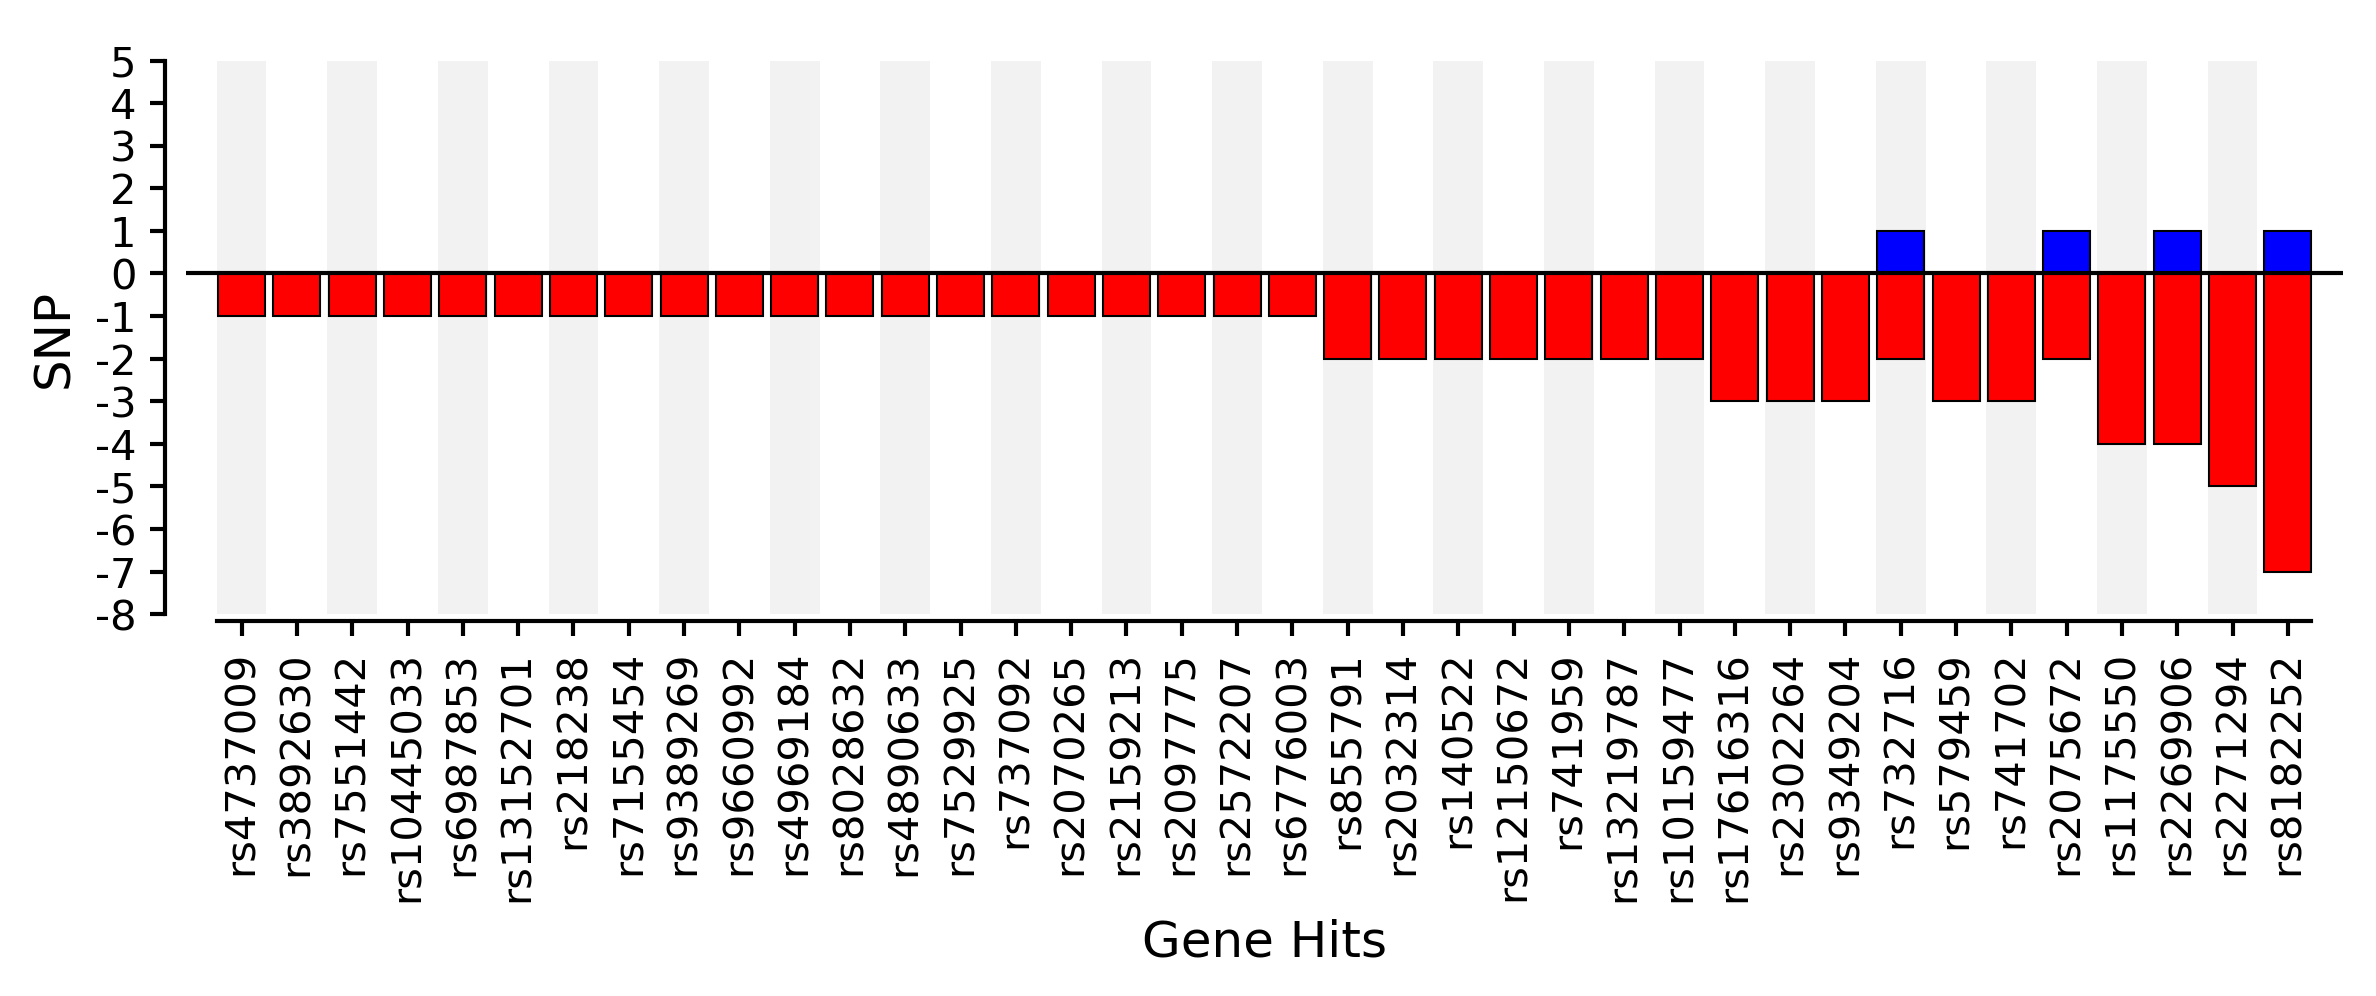

In [59]:
# Plot
fig, ax = plt.subplots(1, figsize=(8,3.4), dpi=300)

width = 0.85

inds = np.arange(0.0, len([x for x in snpHits]))

for i, ind in enumerate(inds):
    if i%2 == 0:
        ax.add_patch(Rectangle((ind-.45, -8), 0.9, 13, facecolor="grey", alpha=0.1))
    else:
        pass

p = ax.bar(inds, [x[1] for x in forPlotPos], width, edgecolor='black', linewidth=0.5, color='blue')

n = ax.bar(inds, [-1 * x[1] for x in forPlotNeg], width, edgecolor='black', linewidth=0.5, color='red')

plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=10)
plt.tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=True)

ax.set_xlabel('Gene Hits', fontsize=12)
ax.set_ylabel('SNP', fontsize=12)

adjust_spines(ax, ['bottom', 'left'])

ax.spines['left'].set_position(('outward', 5))
ax.spines['left'].set_smart_bounds(True)

ax.spines['bottom'].set_position(('outward', -5))
ax.spines['bottom'].set_smart_bounds(True)

ax.set_xticks(np.arange(0.0, len([x for x in snpHits])))
ax.set_yticks(np.arange(-8, 6))
ax.set_yticklabels(np.arange(-8, 6))
ax.set_xticklabels([x[0] for x in forPlot], rotation=90)

ax.set_xlim(-1, len(forPlotNeg))

ax.axhline(0, xmax=len(forPlotNeg), color='black', linewidth=1)

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1) 

plt.tight_layout(True)

In [60]:
# Reset to previous adjust_spines definition
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')

    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

## Hits per Locus Histogram (S3A)

Text(7,7.5,'median = 1')

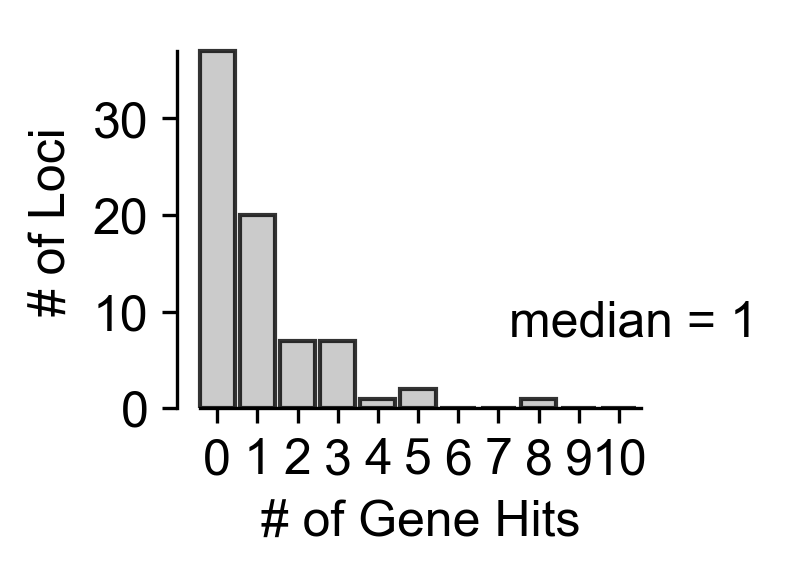

In [61]:
# Per locus histogram
fig, ax = plt.subplots(1, dpi=300, figsize=(2.4, 2))
genesPerLoci = []

for snp in annoref['snp'].unique():
    genesPerLoci.append(len(annoref[annoref['snp'] == snp]['gene'].unique()))

genesPerLoci.append(0)

genesPerLoci = np.array(genesPerLoci)

ax.hist([0]*37 + [x[1] for x in forPlot], bins=11, range=(0,10), width=0.8, fc='0.75', ec='black', alpha=0.8)

adjust_spines(ax, ['left', 'bottom'])

ax.spines['bottom'].set_position(('outward', 0))
ax.spines['bottom'].set_smart_bounds(True)

ax.spines['left'].set_position(('outward', 0))
ax.spines['left'].set_smart_bounds(True)

ax.set_xlabel('# of Gene Hits')
ax.set_ylabel('# of Loci')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.set_xticks([x + 0.4 - 0.09*i for i,x in enumerate(range(0,11))])
ax.set_xticklabels([str(x) for x in range(0,11)])

plt.tight_layout(True)

ax.text(7, 7.5, 'median = ' + str(int(np.median([sum(x[1:]) for x in forPlot]))), fontsize=12, fontname='Arial')

## Correlation of beta value and original GWAS effect size

In [62]:
vdh = pd.read_csv('ref/vanderharst2012.tsv', sep='\t')
print(vdh.shape)
vdh.head()

(75, 7)


,Sentinel SNP,Position (B36),Alleles (EA/OA),EAF,Phenotype,Effect (SE),P
0,rs1175550,3681388,G/A,0.22,MCHC,0.008 (0.013),8.6 × 10−15
1,rs3916164,39842526,G/A,0.71,MCH,0.008 (0.004),3.1 × 10−10
2,rs741959,47448820,G/A,0.57,MCV,0.157 (0.025),6.0 × 10−10
3,rs857684,156842353,C/T,0.74,MCHC,−0.006 (0.011),3.5 × 10−16
4,rs7529925,197273831,C/T,0.28,RBC,0.014 (0.002),8.3 × 10−9


In [63]:
'−0.014'.find('−')

0

In [64]:
betaLookup = modeldf.set_index('gene').to_dict()['betaDur']
vdhLookup = vdh.set_index('Sentinel SNP').to_dict()['Effect (SE)']
genesCol = sorted(geneHits)
snpsCol = [snpLookup[x] for x in genesCol]
betasCol = [betaLookup[x] for x in genesCol]
vdhsCol = [vdhLookup[x] for x in snpsCol]
vdhsCol = [float(x[:x.index(' ')].replace('−', '-')) for x in vdhsCol]
vdhsAbsCol = [abs(x) for x in vdhsCol]

pearsonr(betasCol, vdhsCol)

(0.015873504739020015, 0.89101516613102416)

## Inter-target Hairpin Correlation (S3C)

In [65]:
from scipy.stats import spearmanr

In [66]:
tempHits = phenoRaw[phenoRaw['gene'].isin(geneHits)][['id', 'gene'] + [x for x in phenoRaw.columns if 'pheno-' in x]].copy()
tempNots = phenoRaw[~phenoRaw['gene'].isin(geneHits)][['id', 'gene'] + [x for x in phenoRaw.columns if 'pheno-' in x]].copy()

for day in ['d4', 'd6', 'd9', 'd12', 'd14', 'd16']:
    tempHits[day] = tempHits[[x for x in tempHits.columns if day in x]].mean(axis=1)
    for rep in ['r1', 'r2', 'r3']:
        del(tempHits['pheno-' + rep + day])
        
for day in ['d4', 'd6', 'd9', 'd12', 'd14', 'd16']:
    tempNots[day] = tempNots[[x for x in tempNots.columns if day in x]].mean(axis=1)
    for rep in ['r1', 'r2', 'r3']:
        del(tempNots['pheno-' + rep + day])
        
tempHits['mean'] = tempHits[tempHits.columns[2:]].mean(axis=1)
tempNots['mean'] = tempNots[tempNots.columns[2:]].mean(axis=1)
tempHits = tempHits[tempHits['mean'] > 0]
tempNots = tempNots[tempNots['mean'] > 0]

del(tempHits['mean'])
del(tempNots['mean'])
        
hitCorrs = []
notCorrs = []

for gene in phenoRaw['gene'].values:
    if gene in tempHits['gene'].values:
        subdf = tempHits[tempHits['gene'] == gene].copy()
        for i,sid1 in enumerate(subdf['id'].values):
            for sid2 in subdf['id'].values[i+1:]:
                if sid1 == sid2:
                    pass
                else:
                    hitCorrs.append(pearsonr(subdf[subdf['id'] == sid1][subdf.columns[2:]].values[0],
                                   subdf[subdf['id'] == sid2][[x for x in subdf.columns[2:]]].values[0])[0])   
    else:
        subdf = tempNots[tempNots['gene'] == gene].copy()
        for i,sid1 in enumerate(subdf['id'].values):
            for sid2 in subdf['id'].values[i+1:]:
                if sid1 == sid2:
                    pass
                else:
                    notCorrs.append(pearsonr(subdf[subdf['id'] == sid1][[x for x in subdf.columns[2:]]].values[0],
                                   subdf[subdf['id'] == sid2][ subdf.columns[2:]].values[0])[0])  

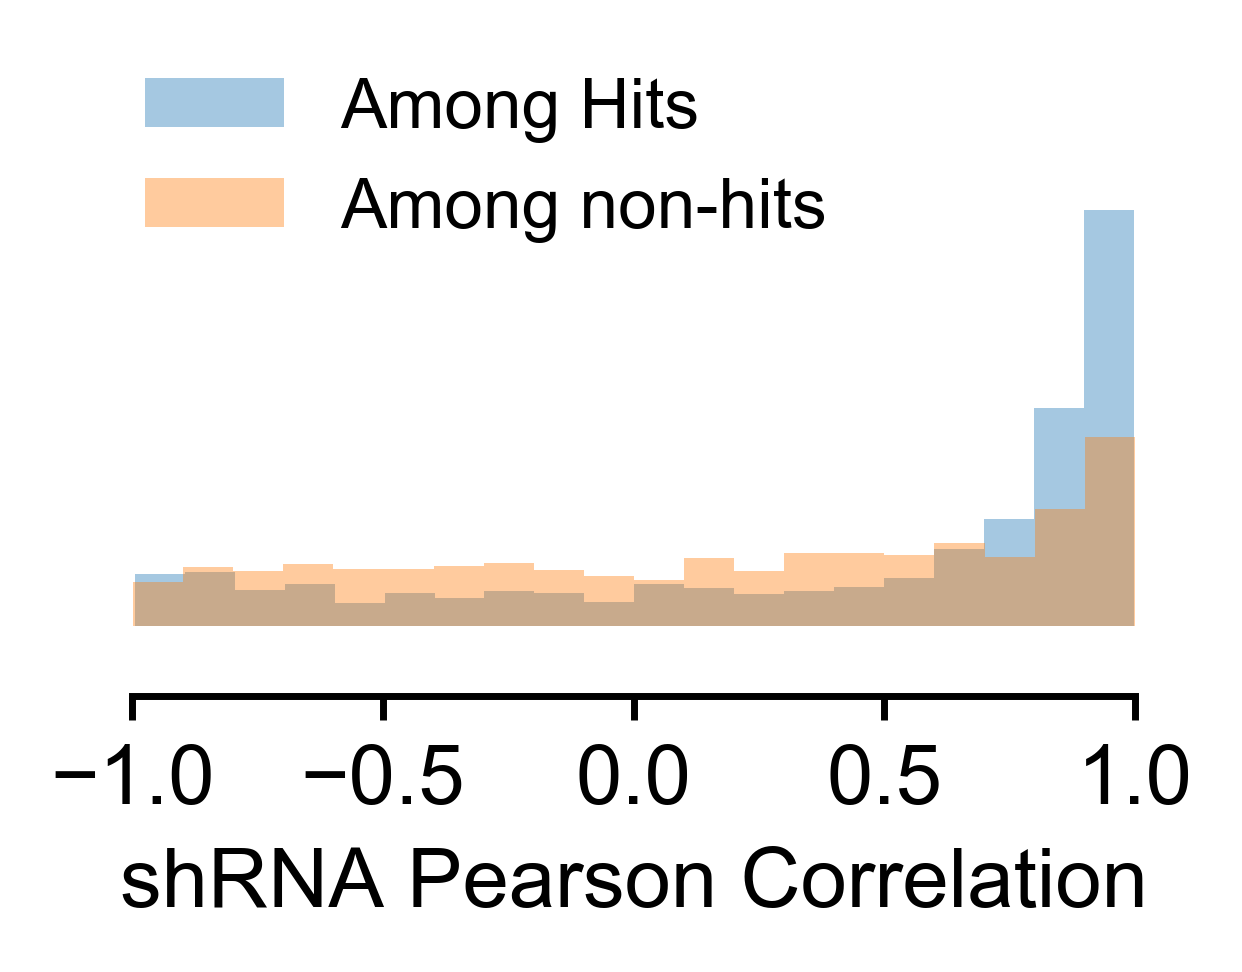

In [84]:
fig, ax = plt.subplots(1, dpi=500, figsize=(2.4,2))

plotdf = pd.DataFrame()
plotdf['plotCol'] = hitCorrs

ax.hist(plotdf['plotCol'].values, label='Among Hits', alpha=0.4, bins=20, density=True)

plotdf = pd.DataFrame()
plotdf['plotCol'] = notCorrs

ax.hist(plotdf['plotCol'].values, label='Among non-hits', alpha=0.4, bins=20, density=True)

#ax.set_ylabel('Probability Density')
ax.set_xlabel('shRNA Pearson Correlation')

adjust_spines(ax, ['bottom'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
lgd = ax.legend(ncol=1, frameon=False, fontsize=10, loc='upper left', prop=font, bbox_to_anchor=(0.0,1.4))

plt.tight_layout(False)

## Essentiality enrichment (3B, S3D-G)

In [68]:
ess = pd.read_csv('ref/Wang2015_TableS3_CRISPRScores.txt', sep='\t')
ess = ess[['Gene', 'sgRNAs included'] + [x for x in ess.columns if 'K562' in x]]
print(ess.shape)
ess.head()

(18166, 4)


,Gene,sgRNAs included,K562 CS,K562 adjusted p-value
0,A1BG,9,-0.220,0.951988
1,A1CF,7,-0.984,0.100374
2,A2M,10,-0.520,0.837712
3,A2ML1,10,-0.646,0.579034
4,A4GALT,10,-0.582,0.695675


In [69]:
trueHits = geneHits.copy()

In [70]:
LENmod = 1.0
cutoffMod = 1.5

In [71]:
hitEss = {}
for key in trueHits:
    hitEss[key] = []
    try:
        hitEss[key].append(ess[ess['Gene'] == key]['K562 CS'].values[0])
    except:
        pass
            
for key in hitEss.keys():
    hitEss[key] = np.array([x for x in hitEss[key] if x < 0])
    hitEss[key] = np.array(sorted(hitEss[key]))

print(len(hitEss))

delKeys = []
for key in hitEss.keys():
    if len(hitEss[key]) < 1:
        delKeys.append(key)
        
for key in delKeys:
    del(hitEss[key])
        
maxHits = len(hitEss)
        
print(len(hitEss))

77
67


In [72]:
otherLists = [x for x in glob('ref/otherGWASGenes/*')]

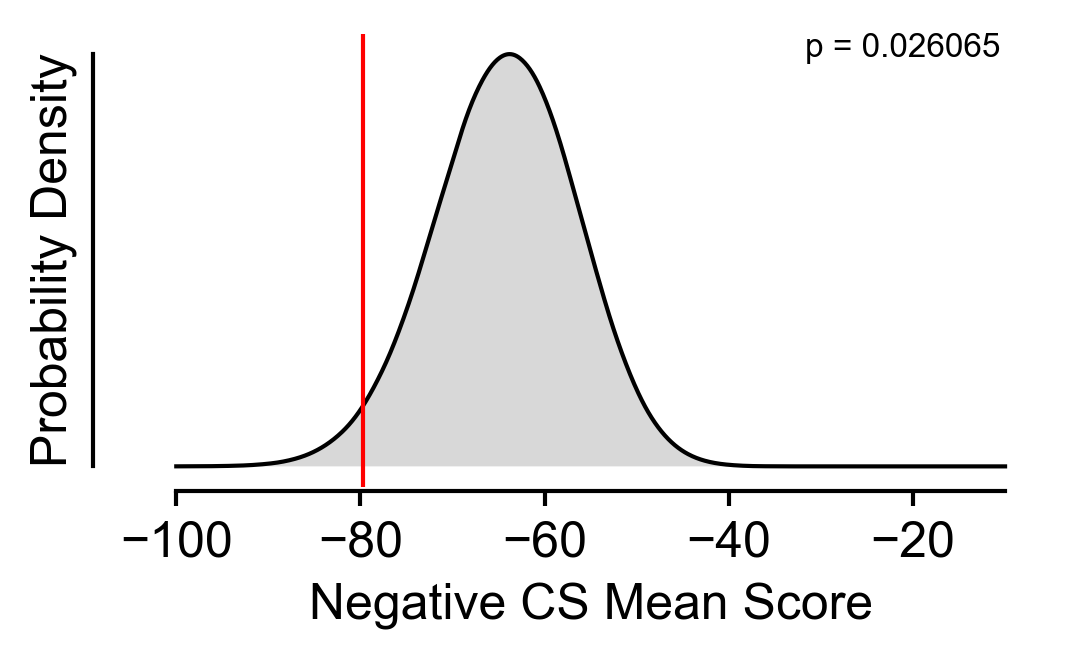

In [73]:
# Plotting the negative CS mean score densities hits vs. library
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

PERMS = 1000000
bw = 0.5

essNeg = ess[ess['K562 CS'] < 0]

ourMeans = []

LEN = int(len(hitEss)*LENmod)
bench = sum([x[0] for x in hitEss.values()])

screenEss = essNeg[essNeg['Gene'].isin(shref[shref['type'] == 'gwa']['gene'].values)]

screenPerm = []
for j in range(PERMS):
    subperm = np.sort(np.random.choice(screenEss['K562 CS'], size=LEN, replace=False))
    screenPerm.append(subperm.sum())

screenPerm = np.array(screenPerm)
ourMeans.append(screenPerm.mean())

xMin = -100
xMax = -10

xVals = np.linspace(xMin, xMax, 1000)
yVals = kdestimate(screenPerm, xVals, bandwidth=1)

adjust_spines(ax, ['bottom', 'left'])
screen = ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.6, label='Screen')
ax.plot(xVals, yVals, color='black', linewidth=1)

ax.spines['bottom'].set_position(('outward', 1))
ax.spines['bottom'].set_smart_bounds(True)

ax.tick_params(
axis='y',
which='both',
left=False,
right=False,
labelleft=False)

ax.set_ylabel('Probability Density')

ax.axvline(bench, lw=1, color='red')

ax.set_xlabel('Negative CS Mean Score')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

ax.text(0.95, 1.0, 'p = ' + str(len(screenPerm[screenPerm < bench])/PERMS), fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

plt.tight_layout(False)

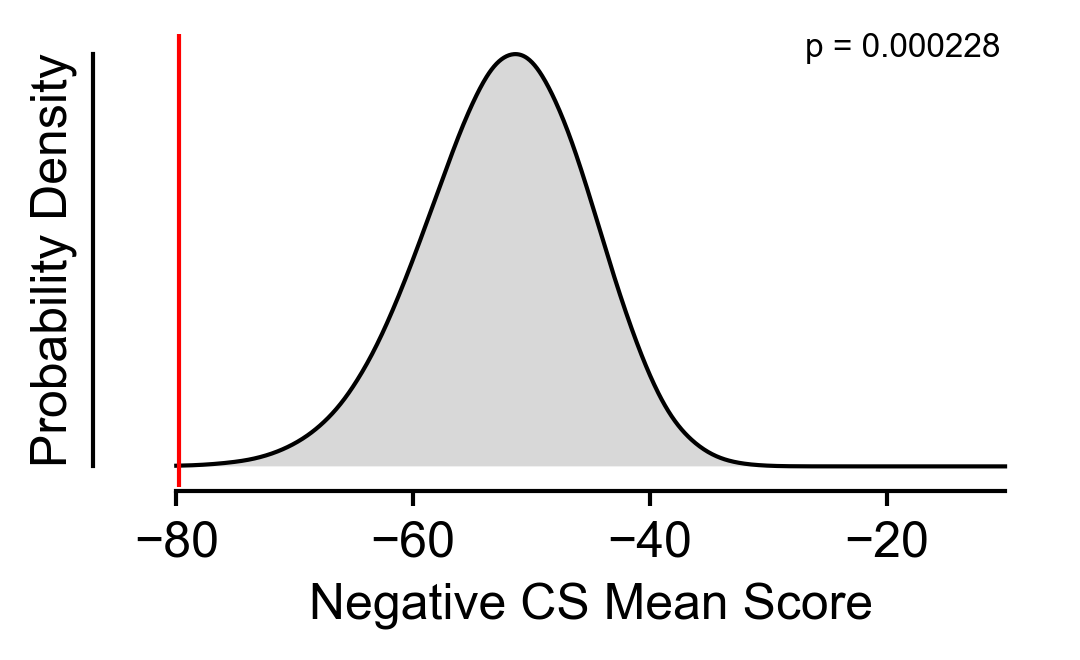

In [74]:
# Plotting the negative CS mean score densities hits vs. genome
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

PERMS = 1000000
bw = 0.5

essNeg = ess[ess['K562 CS'] < 0]

ourMeans = []

LEN = int(len(hitEss)*LENmod)
bench = sum([x[0] for x in hitEss.values()])

perm = []
for j in range(PERMS):
    subperm = np.sort(np.random.choice(essNeg['K562 CS'], size=LEN, replace=False))
    perm.append(subperm.sum())

perm = np.array(perm)

xMin = -80
xMax = -10


xVals = np.linspace(xMin, xMax, 1000)
yVals = kdestimate(perm, xVals, bandwidth=1)

adjust_spines(ax, ['bottom', 'left'])
genome = ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.6, label='Genome')
ax.plot(xVals, yVals, color='black', linewidth=1)

ax.spines['bottom'].set_position(('outward', 1))
ax.spines['bottom'].set_smart_bounds(True)

ax.tick_params(
axis='y',
which='both',
left=False,
right=False,
labelleft=False)

ax.set_ylabel('Probability Density')

ax.axvline(bench, lw=1, color='red')

ax.set_xlabel('Negative CS Mean Score')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

ax.text(0.95, 1.0, 'p = ' + formatx10(len(perm[perm < bench])/PERMS), fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

plt.tight_layout(False)

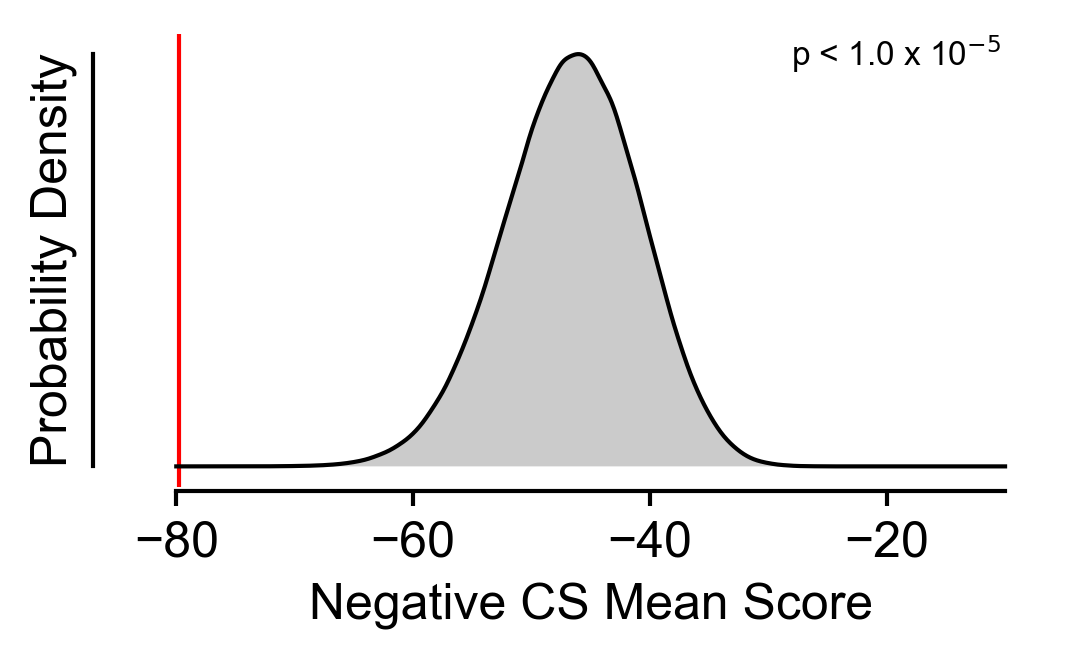

In [75]:
# Plotting the negative CS mean score densities hits vs. Triglycerides
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

PERMS = 1000000
bw = 0.5

essNeg = ess[ess['K562 CS'] < 0]

ourMeans = []

LEN = int(len(hitEss)*LENmod)
bench = sum([x[0] for x in hitEss.values()])

xMin = -80
xMax = -10

xVals = np.linspace(xMin, xMax, 1000)

adjust_spines(ax, ['bottom', 'left'])

ax.spines['bottom'].set_position(('outward', 1))
ax.spines['bottom'].set_smart_bounds(True)

ax.tick_params(
axis='y',
which='both',
left=False,
right=False,
labelleft=False)

ax.set_ylabel('Probability Density')

ax.axvline(bench, lw=1, color='red')

ax.set_xlabel('Negative CS Mean Score')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

# Set to True to include the otherGwas
if True:  
    otherList = otherLists[0]
    otherdf = pd.read_csv(otherList)
    otherEss = essNeg[essNeg['Gene'].isin(otherdf['gene'].values)]

    greaterDays = []

    LEN = int(len(hitEss)*LENmod)
    otherPerm = []
    for j in range(PERMS):
        subperm = np.sort(np.random.choice(otherEss['K562 CS'], size=LEN, replace=False))
        otherPerm.append(subperm.sum())

    otherPerm = np.array(otherPerm)

    yVals = kdestimate(otherPerm, xVals, bandwidth=bw)
    ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.8)
    ax.plot(xVals, yVals, color='black', linewidth=1)

if len(otherPerm[otherPerm < bench]) == 0:
    ax.text(0.95, 1.0, 'p < 1.0 x 10' + r'$^{-5}$', fontsize=8, fontname='Arial', verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
else:
    ax.text(0.95, 1.0, 'p = ' + formatx10(len(otherPerm[otherPerm < bench])/PERMS), fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

plt.tight_layout(False)

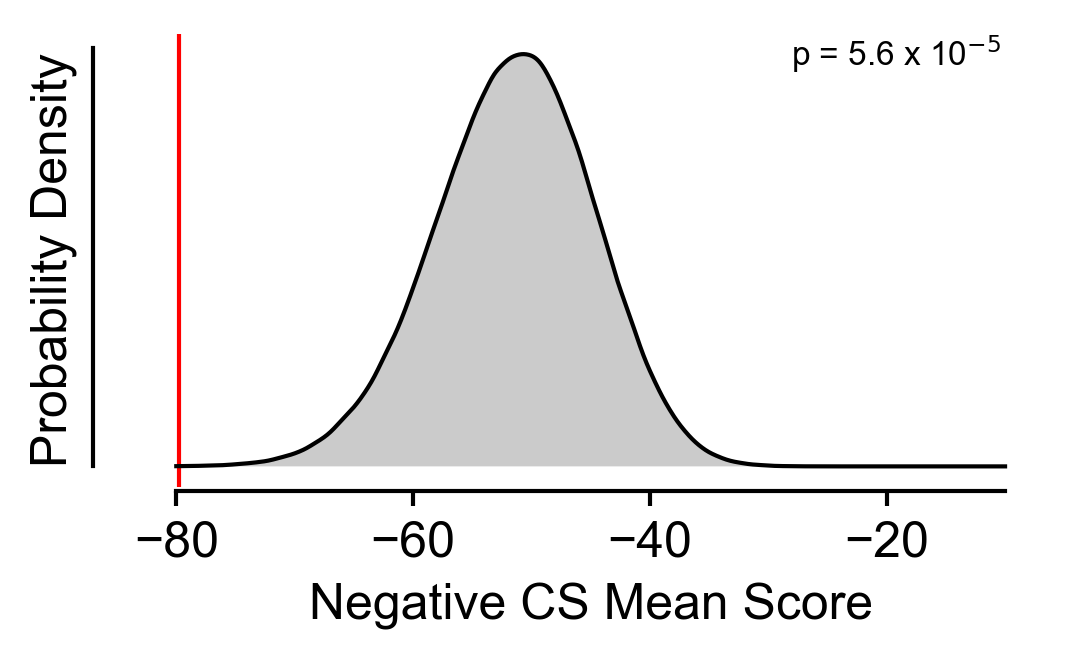

In [76]:
# Plotting the negative CS mean score densities hits vs. LDL
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

PERMS = 1000000
bw = 0.5

essNeg = ess[ess['K562 CS'] < 0]

ourMeans = []

LEN = int(len(hitEss)*LENmod)
bench = sum([x[0] for x in hitEss.values()])

xMin = -80
xMax = -10

xVals = np.linspace(xMin, xMax, 1000)

adjust_spines(ax, ['bottom', 'left'])

ax.spines['bottom'].set_position(('outward', 1))
ax.spines['bottom'].set_smart_bounds(True)

ax.tick_params(
axis='y',
which='both',
left=False,
right=False,
labelleft=False)

ax.set_ylabel('Probability Density')

ax.axvline(bench, lw=1, color='red')

ax.set_xlabel('Negative CS Mean Score')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

# Set to True to include the otherGwas
if True:  
    otherList = otherLists[1]
    otherdf = pd.read_csv(otherList)
    otherEss = essNeg[essNeg['Gene'].isin(otherdf['gene'].values)]

    greaterDays = []

    LEN = int(len(hitEss)*LENmod)
    otherPerm = []
    for j in range(PERMS):
        subperm = np.sort(np.random.choice(otherEss['K562 CS'], size=LEN, replace=False))
        otherPerm.append(subperm.sum())

    otherPerm = np.array(otherPerm)

    yVals = kdestimate(otherPerm, xVals, bandwidth=bw)
    ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.8)
    ax.plot(xVals, yVals, color='black', linewidth=1)

if len(otherPerm[otherPerm < bench]) == 0:
    ax.text(0.95, 1.0, 'p < 1.0 x 10' + r'$^{-5}$', fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
else:
    ax.text(0.95, 1.0, 'p = ' + formatx10(len(otherPerm[otherPerm < bench])/PERMS), fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

plt.tight_layout(False)

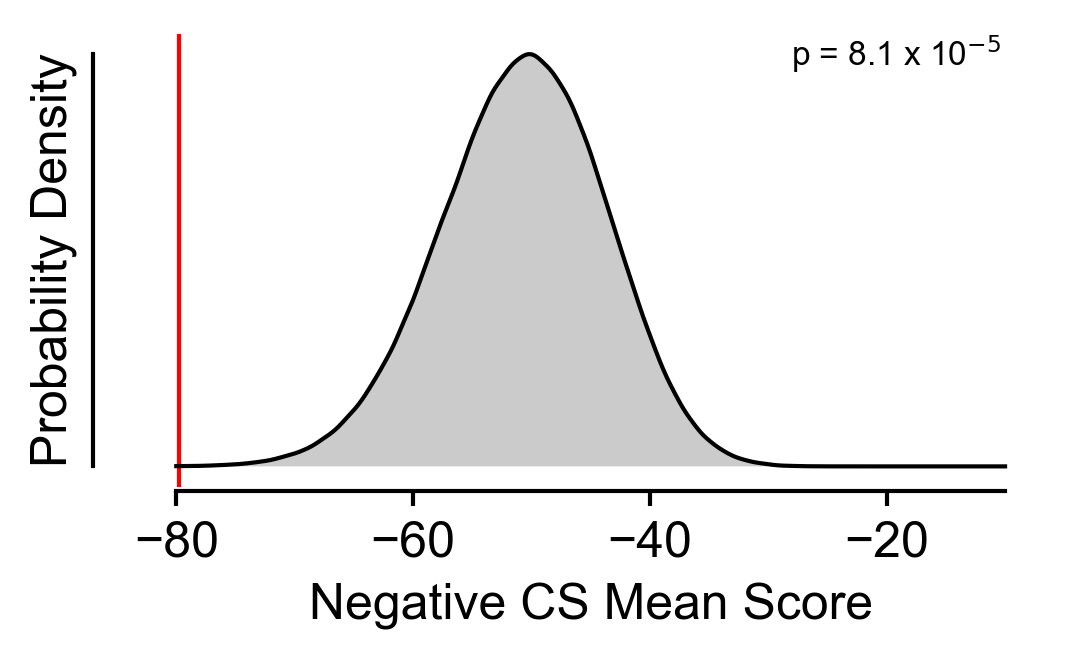

In [77]:
# Plotting the negative CS mean score densities hits vs. HDL
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

PERMS = 1000000
bw = 0.5

essNeg = ess[ess['K562 CS'] < 0]

ourMeans = []

LEN = int(len(hitEss)*LENmod)
bench = sum([x[0] for x in hitEss.values()])

xMin = -80
xMax = -10

xVals = np.linspace(xMin, xMax, 1000)

adjust_spines(ax, ['bottom', 'left'])

ax.spines['bottom'].set_position(('outward', 1))
ax.spines['bottom'].set_smart_bounds(True)

ax.tick_params(
axis='y',
which='both',
left=False,
right=False,
labelleft=False)

ax.set_ylabel('Probability Density')

ax.axvline(bench, lw=1, color='red')

ax.set_xlabel('Negative CS Mean Score')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

# Set to True to include the otherGwas
if True:  
    otherList = otherLists[2]
    otherdf = pd.read_csv(otherList)
    otherEss = essNeg[essNeg['Gene'].isin(otherdf['gene'].values)]

    greaterDays = []

    LEN = int(len(hitEss)*LENmod)
    otherPerm = []
    for j in range(PERMS):
        subperm = np.sort(np.random.choice(otherEss['K562 CS'], size=LEN, replace=False))
        otherPerm.append(subperm.sum())

    otherPerm = np.array(otherPerm)

    yVals = kdestimate(otherPerm, xVals, bandwidth=bw)
    ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.8)
    ax.plot(xVals, yVals, color='black', linewidth=1)

if len(otherPerm[otherPerm < bench]) == 0:
    ax.text(0.95, 1.0, 'p < 1.0 x 10' + r'$^5$', fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
else:
    ax.text(0.95, 1.0, 'p = ' + formatx10(len(otherPerm[otherPerm < bench])/PERMS), fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

plt.tight_layout(False)

## Gold Standard Rank Sum Permutation (3C)

In [78]:
golds = ['CCND3', 'SH2B3', 'MYB', 'KIT', 'RBM38']

In [79]:
from random import sample
from scipy.stats import rankdata

temp = modeldf.copy()
temp['qRank'] = rankdata(temp['qval'].values)
bench = temp[temp['gene'].isin(golds)]['qRank'].sum()
print('bench', bench)

ranks = list(temp['qRank'].values)

numReps = 1000000
perms = []
for rep in range(10000):
    perms.append(sum(sample(ranks, 5)))
    
perms = np.array(perms)
print(sum(perms <= bench)/10000)

bench 520.5
0.028


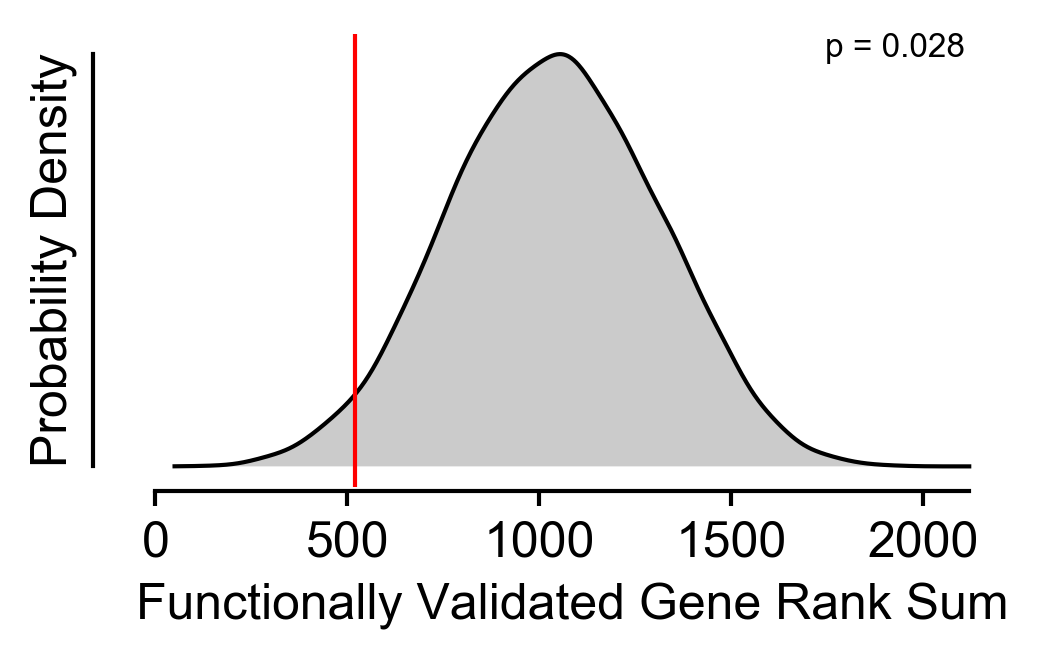

In [80]:
###### Plotting the gold standard permutation
fig, ax = plt.subplots(1, figsize=(3.4,2),dpi=300)

xMin = 50
xMax = 2120

xVals = np.linspace(xMin, xMax, 1000)
yVals = kdestimate(perms, xVals, bandwidth=50)

adjust_spines(ax, ['bottom', 'left'])
perm = ax.fill_between(xVals, yVals, facecolor='0.75', alpha=0.8, label='Permuted Rank Sums')
ax.plot(xVals, yVals, color='black', linewidth=1)

ax.spines['bottom'].set_position(('outward', 1))
ax.spines['bottom'].set_smart_bounds(True)

ax.tick_params(
axis='y',
which='both',
left=False,
right=False,
labelleft=False)

ax.set_ylabel('Probability Density')

ax.axvline(bench, lw=1, color='red')

ax.set_xlabel('Functionally Validated Gene Rank Sum')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

ax.text(0.95, 1.0, 'p = ' + str(sum(perms <= bench)/10000), fontname='Arial', fontsize=8, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

plt.tight_layout(False)

## Hits per Trait (S3B)

In [113]:
snpTraits = {}
for snp in traitref['SNP'].unique():
    snpTraits[snp] = list(traitref[traitref['SNP'] == snp]['Pheno'].unique())

In [114]:
traitCounts = {}
for trait in traitref['Pheno'].unique():
    traitCounts[trait] = 0
        
traitCounts

{'MCHC': 0, 'MCV': 0, 'RBC': 0, 'MCH': 0, 'Hb': 0, 'PCV': 0}

In [115]:
for snp in [x[0] for x in forPlot]:
    traitref = snpTraits[snp]
    for trait in traitref:
        traitCounts[trait] += 1

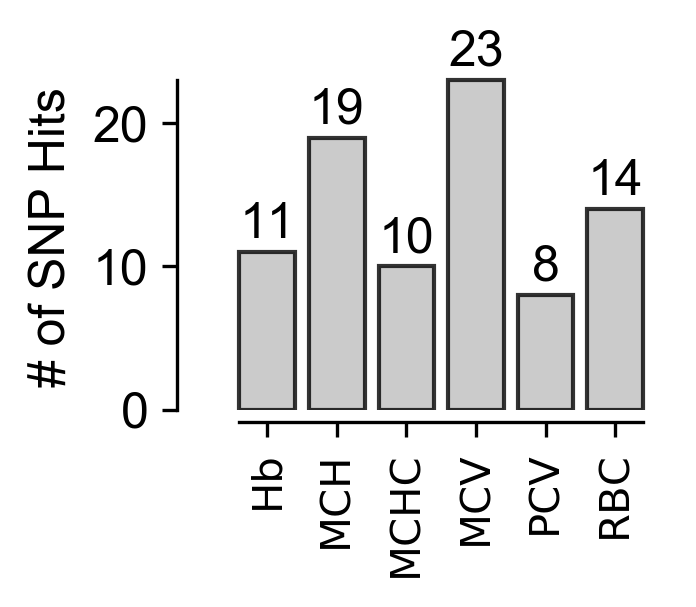

In [118]:
# Plotting snp hits per trait
fig, ax = plt.subplots(1, figsize=(2.4,2),dpi=300)

adjust_spines(ax, ['bottom', 'left'])

traitVals = [traitCounts[x] for x in traits]

ax.bar(range(len(traitVals)), traitVals, fc='0.75', ec='black', alpha=0.8)
    
ax.set_xticks(range(len(traitVals)))
ax.set_xticklabels(traits, rotation=90)

ax.set_ylabel('# of SNP Hits', fontsize=12)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

for x in range(len(traitVals)):
    ax.text(x, traitVals[x]+1, traitVals[x], fontname='Arial', fontsize=12, ha='center')

ax.spines['bottom'].set_position(('outward', 3))
    
ax.set_xticklabels(traits, rotation=90)
    
plt.tight_layout(True)

## eQTL Comparison to LD

In [85]:
eqAll = pd.read_csv('newPanels/eqtl_nominate/eqtl_nominate/gtex_blood_eqtl_ALLGENES.txt', sep='\t', names=['gene'])
print(eqAll.shape)
eqAll.head()
eqAll = list(eqAll['gene'].values)

(8661, 1)


In [86]:
eqNom = pd.read_csv('newPanels/eqtl_nominate/eqtl_nominate/gtex_blood_eqtl_NOMINATED.txt', sep='\t', names=['gene'])
print(eqNom.shape)
eqNom.head()
eqNom = list(eqNom['gene'].values)

(139, 1)


In [87]:
ldAll = list(annoref[annoref['anno'] == 'gwa']['gene'].values)
ldNom = geneHits[:]
print(len(eqAll), len(eqNom))
print(len(ldAll), len(ldNom))

8661 139
389 77


In [88]:
commonGenes = [x for x in ldAll if x in eqAll]
print(len(commonGenes))
commonNoms = [x for x in ldNom if x in eqNom]
print(len(commonNoms))

153
0


In [89]:
print(len([x for x in eqNom if x in commonGenes]))
print(len([x for x in ldNom if x in commonGenes]))

0
35


In [90]:
len([x for x in eqNom if x in ldAll])

0

In [95]:
len([x for x in trueHits if x in eqAll])

35

In [91]:
8661-139

8522

In [98]:
import scipy.stats as stats

In [99]:
stats.fisher_exact([[8522, 35], [139, 0]])

(0.0, 1.0)

In [100]:
stats.fisher_exact([[8522, 139], [35, 0]])

(0.0, 1.0)

# Cell Type Expression Enrichment Heat Map (3E, S3G)

In [91]:
trueHits = geneHits.copy()
print(len(trueHits))

77


In [92]:
erydf = pd.read_csv('ref/expressionData/16populations_RNAcounts.tsv', sep='\t')
erydf = erydf.rename(columns={'Genes':'gene'})
for col in erydf.columns[1:]:
    erydf[col] = np.log2((erydf[col].values+1) / erydf[col].sum() * 1e6)
    
tempCPM = zscore(erydf[[x for x in erydf.columns[1:]]].values, axis=1)

for i,col in enumerate(erydf.columns[1:]):
    erydf[col] = tempCPM[:,i]

erydf.head()

,gene,HSC,MPP,LMPP,CLP,GMP-A,GMP-B,GMP-C,CMP,MEP,NK,CD4,CD8,B,pDC,Mono,Ery
0,TSPAN6,1.609413,1.095595,0.384499,-0.872402,-0.957141,-0.938555,-1.262848,0.357237,1.193969,-0.095808,1.179363,1.291066,-0.763613,-0.133705,-1.548375,-0.538694
1,TNMD,-0.692547,-1.101209,0.148152,0.141906,1.355591,1.442409,-0.072383,-1.445015,-1.398775,-0.391088,1.437265,1.140661,-0.291435,0.373389,-1.406093,0.759172
2,DPM1,0.510289,0.372844,0.564784,0.712665,-2.458616,-1.652696,-1.774676,0.456420,0.972919,0.121546,0.867224,0.827573,0.296462,-0.240396,0.157023,0.266636
3,SCYL3,0.468378,0.356443,0.588165,0.770003,-2.001918,-1.215180,-1.585387,-0.132718,-0.156909,1.076950,1.191268,0.956017,1.222776,-1.116563,-0.629677,0.208351
4,C1orf112,0.010819,-0.382073,1.094874,2.015998,-0.706058,-0.183850,-0.482969,0.635639,1.177667,-0.570565,-0.907133,-0.797632,-0.708065,-0.534079,-1.475399,1.812826


In [93]:
gsedf = pd.read_csv('ref/expressionData/GSE107218_CBPB-hg19-counts.csv', sep=',', header=1)
gsedf = gsedf[[x for x in gsedf.columns if x not in ['Chr', 'Start', 'End', 'Strand']]]
gsedf = gsedf.rename(columns={'Geneid':'gene'})

tempPool = [x[:x.rfind('-')] for x in gsedf.columns if '-' in x]
poolCols = []
for col in tempPool:
    if col not in poolCols:
        poolCols.append(col)
    else:
        continue

pooldf = pd.DataFrame()
pooldf['gene'] = gsedf['gene'].values

for col in poolCols:
    pooldf[col] = gsedf[[x for x in gsedf.columns if col in x]].mean(axis=1)

cbdf = pooldf[['gene'] + [x for x in pooldf.columns if 'CB-' in x]].copy()
pbdf = pooldf[['gene'] + [x for x in pooldf.columns if 'PB-' in x]].copy()

print(pooldf.shape)
print(cbdf.shape)
print(pbdf.shape)
pooldf.head()

(23710, 17)
(23710, 9)
(23710, 9)


,gene,CB-CD34,CB-BFUE,CB-CFUE,CB-ProE,CB-eBaso,CB-lBaso,CB-Poly,CB-Ortho,PB-CD34,PB-BFUE,PB-CFUE,PB-Pro,PB-eBaso,PB-lBaso,PB-Poly,PB-Ortho
0,DDX11L1,256.666667,95.666667,100.000000,41.0,54.666667,70.333333,91.000000,21.666667,185.000000,21.666667,48.000000,42.666667,37.666667,56.333333,84.666667,28.333333
1,WASH7P,4571.333333,4405.000000,6058.666667,6141.0,9074.333333,10524.000000,9072.666667,2099.333333,3611.666667,3561.000000,3565.333333,4295.333333,4914.000000,5798.000000,3700.666667,823.000000
2,FAM138A,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,FAM138F,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,OR4F5,0.333333,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000


In [94]:
for col in cbdf.columns[1:]:
    cbdf[col] = np.log2((cbdf[col].values+1) / cbdf[col].sum() * 1e6)
    
tempCPM = zscore(cbdf[[x for x in cbdf.columns[1:]]].values, axis=1)

for i,col in enumerate(cbdf.columns[1:]):
    cbdf[col] = tempCPM[:,i]

cbdf.head()

,gene,CB-CD34,CB-BFUE,CB-CFUE,CB-ProE,CB-eBaso,CB-lBaso,CB-Poly,CB-Ortho
0,DDX11L1,1.974985,0.491946,0.442577,-0.630365,-0.501604,-0.150804,0.099514,-1.726249
1,WASH7P,0.155665,-0.324254,0.148994,0.220730,0.645447,1.006864,0.598351,-2.451797
2,FAM138A,2.021172,0.759748,0.239508,0.378310,-0.741365,-0.543511,-0.886740,-1.227122
3,FAM138F,2.021172,0.759748,0.239508,0.378310,-0.741365,-0.543511,-0.886740,-1.227122
4,OR4F5,1.635663,-0.003662,-0.282354,-0.207997,-0.807805,1.619861,-0.885682,-1.068024


In [95]:
for col in pbdf.columns[1:]:
    pbdf[col] = np.log2((pbdf[col].values+1) / pbdf[col].sum() * 1e6)
    
tempCPM = zscore(pbdf[[x for x in pbdf.columns[1:]]].values, axis=1)

for i,col in enumerate(pbdf.columns[1:]):
    pbdf[col] = tempCPM[:,i]

pbdf.head()

,gene,PB-CD34,PB-BFUE,PB-CFUE,PB-Pro,PB-eBaso,PB-lBaso,PB-Poly,PB-Ortho
0,DDX11L1,2.409656,0.042611,-0.191142,-0.538368,-0.676328,-0.099120,0.215340,-1.162649
1,WASH7P,0.612585,1.286309,-0.037085,0.054293,0.284757,0.521022,-0.383967,-2.337915
2,FAM138A,0.962378,2.249175,-0.208425,-0.530715,-0.458544,-0.457119,-0.950112,-0.606638
3,FAM138F,0.962378,2.249175,-0.208425,-0.530715,-0.458544,-0.457119,-0.950112,-0.606638
4,OR4F5,0.923268,2.292916,-0.322919,-0.665960,-0.589142,-0.587626,-0.303766,-0.746771


In [96]:
print('erydf', erydf[erydf['gene'].isin(trueHits)].shape)
print('cbdf', cbdf[cbdf['gene'].isin(trueHits)].shape)
print('pbdf', pbdf[pbdf['gene'].isin(trueHits)].shape)

erydf (76, 17)
cbdf (76, 9)
pbdf (76, 9)


In [97]:
cbdf = cbdf.replace('DUS2L', 'DUS2')
pbdf = pbdf.replace('DUS2L', 'DUS2')

commonGenes = [x for x in cbdf['gene'].values if x in set(erydf['gene'].values)]

erydf = erydf[erydf['gene'].isin(commonGenes)].sort_values('gene').drop_duplicates('gene')
cbdf = cbdf[cbdf['gene'].isin(commonGenes)].sort_values('gene').drop_duplicates('gene')
pbdf = pbdf[pbdf['gene'].isin(commonGenes)].sort_values('gene').drop_duplicates('gene')

print(erydf.shape, cbdf.shape, pbdf.shape)

(19621, 17) (19621, 9) (19621, 9)


In [98]:
alldf = pd.DataFrame()
alldf['gene'] = erydf['gene'].values

for col in erydf.columns[1:]:
    alldf['H-' + col] = erydf[col].values
    
for col in cbdf.columns[1:]:
    alldf[col] = cbdf[col].values
    
for col in pbdf.columns[1:]:
    alldf[col] = pbdf[col].values

print(alldf.shape)
alldf.head()

(19621, 33)


,gene,H-HSC,H-MPP,H-LMPP,H-CLP,H-GMP-A,H-GMP-B,H-GMP-C,H-CMP,H-MEP,...,CB-Poly,CB-Ortho,PB-CD34,PB-BFUE,PB-CFUE,PB-Pro,PB-eBaso,PB-lBaso,PB-Poly,PB-Ortho
0,A1BG,0.360971,0.313918,0.357856,0.926903,0.533794,0.622366,0.944610,-0.515285,-1.634442,...,-0.289758,-1.246632,1.653559,1.380124,0.608660,-0.245153,-0.792092,-0.705911,-0.974650,-0.924537
1,A1BG-AS1,0.363471,1.613998,1.314744,0.267675,0.998249,-1.054938,-1.524416,-1.159204,-0.089605,...,-1.428421,-0.794853,1.080539,1.520955,1.061457,-0.281152,-0.738087,-0.390217,-0.930235,-1.323259
2,A1CF,-0.774263,-0.369657,-0.491002,-0.493107,-0.084173,-0.054921,-0.565308,-1.027796,-0.469918,...,-0.431895,-1.205137,0.747126,1.958321,0.914794,-0.658245,-0.590314,-0.588973,-1.053002,-0.729707
3,A2M,0.708702,0.458238,0.270526,0.259961,-1.103059,-1.458497,-0.909596,0.038022,-0.593519,...,-0.266806,0.051649,1.606553,0.793703,0.199859,0.979343,-0.426632,-0.614702,-1.336347,-1.201778
4,A2M-AS1,1.086215,0.887157,0.664380,-0.488281,-0.905038,-0.235906,-1.022978,0.720332,0.353544,...,-0.838373,-1.062479,1.917369,1.165921,0.455618,-0.329019,-0.671172,-0.670825,-0.975750,-0.892142


In [99]:
allScreendf = alldf[alldf['gene'].isin(shref[shref['type'] == 'gwa']['gene'].values)].copy()
print(allScreendf.shape)
allScreendf.head()

(383, 33)


,gene,H-HSC,H-MPP,H-LMPP,H-CLP,H-GMP-A,H-GMP-B,H-GMP-C,H-CMP,H-MEP,...,CB-Poly,CB-Ortho,PB-CD34,PB-BFUE,PB-CFUE,PB-Pro,PB-eBaso,PB-lBaso,PB-Poly,PB-Ortho
71,ABCF1,-0.715129,-0.590825,0.247331,-0.747764,1.159405,1.092059,0.156361,0.168496,1.122360,...,-1.106924,-0.811348,-0.944205,1.521758,1.104556,0.421138,0.503536,-0.215066,-1.538914,-0.852802
116,ACAD10,0.634884,0.343594,0.942273,0.519105,-1.915488,-0.145372,-1.881756,-0.091527,0.551882,...,-0.601006,-2.438988,0.147447,0.520360,0.573656,0.683654,0.629698,0.567792,-0.749893,-2.372714
122,ACADS,-0.001265,0.035714,0.465721,-1.894483,1.666090,0.791032,1.564601,0.257291,0.927018,...,-0.511771,-1.910995,-0.530295,-0.174959,-0.031462,1.132318,1.080197,0.942698,-0.365160,-2.053338
138,ACD,0.269122,0.381321,0.364988,-1.484385,0.699431,0.457919,1.289708,0.547646,0.599248,...,-0.917707,-2.289132,0.563303,0.635344,0.758041,0.584457,0.491039,0.382142,-1.436195,-1.978131
164,ACOXL,-0.026057,-0.341294,-0.619104,-0.623923,0.312302,0.379272,-0.789222,-0.606502,0.155429,...,1.503671,1.057800,0.036329,1.541654,-1.432024,-0.928818,0.196026,-0.863414,1.385831,0.064416


In [100]:
allHitsdf = alldf[alldf['gene'].isin(trueHits)].copy()
print(allHitsdf.shape)
allHitsdf.head()

(76, 33)


,gene,H-HSC,H-MPP,H-LMPP,H-CLP,H-GMP-A,H-GMP-B,H-GMP-C,H-CMP,H-MEP,...,CB-Poly,CB-Ortho,PB-CD34,PB-BFUE,PB-CFUE,PB-Pro,PB-eBaso,PB-lBaso,PB-Poly,PB-Ortho
648,ANK1,-0.376368,0.336583,-1.219494,-0.193238,0.321472,0.102531,-1.479494,0.812953,1.795496,...,0.828673,0.622960,-2.321064,-0.761149,0.159441,0.402720,0.505262,0.615424,1.040679,0.358688
688,ANKRD27,0.013117,0.380074,0.874271,-0.933133,0.926044,0.975208,0.722935,1.253762,1.910030,...,-0.665509,-0.227872,-1.442178,0.590448,1.899993,0.860921,-0.177970,-0.813331,-0.689051,-0.228832
861,APOPT1,0.379846,0.435138,0.617293,-0.478288,0.323083,-0.641743,-3.250309,0.564010,0.769311,...,-0.953306,-2.137925,0.110081,0.171602,0.943322,0.848695,0.683760,0.489524,-1.193562,-2.053422
1009,ARL5C,-0.310775,0.040317,0.001286,1.539240,0.299371,2.013697,-0.450502,-0.159593,-1.407727,...,-0.689577,-0.750759,2.402716,0.729442,-0.375130,-0.519984,-0.487547,-0.486906,-0.708483,-0.554108
1225,ATP2B4,0.858736,0.896131,0.463348,0.638119,-0.929917,-0.482980,-0.243420,0.496728,0.215244,...,-1.290696,-1.697991,-1.150430,-0.810886,0.524490,1.249042,1.137597,0.865149,-0.410427,-1.404535


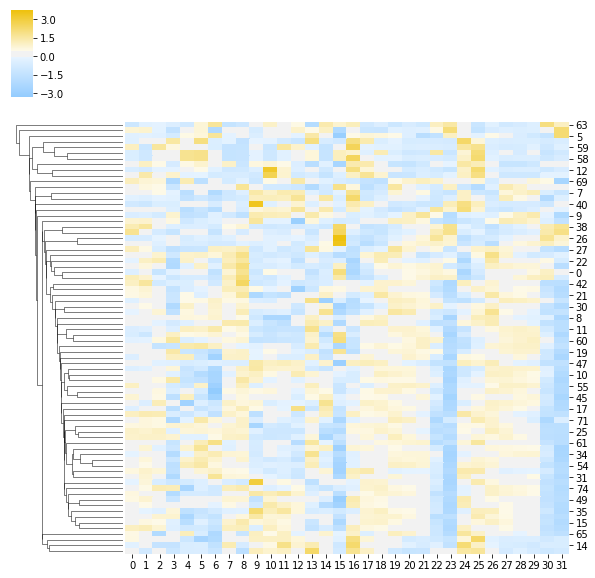

In [101]:
# Use seaborn to generate the initial heatmap
indf = allHitsdf.copy()

celltypes = np.array([x for x in indf.columns[1:]])
genes = indf['gene'].values

C = sns.diverging_palette(240, 65, s=99, l=80, sep=20, center='light', as_cmap=True)
g = sns.clustermap(indf[[x for x in indf.columns[1:]]].values, cmap=C, row_cluster=True, col_cluster=False, method='single')

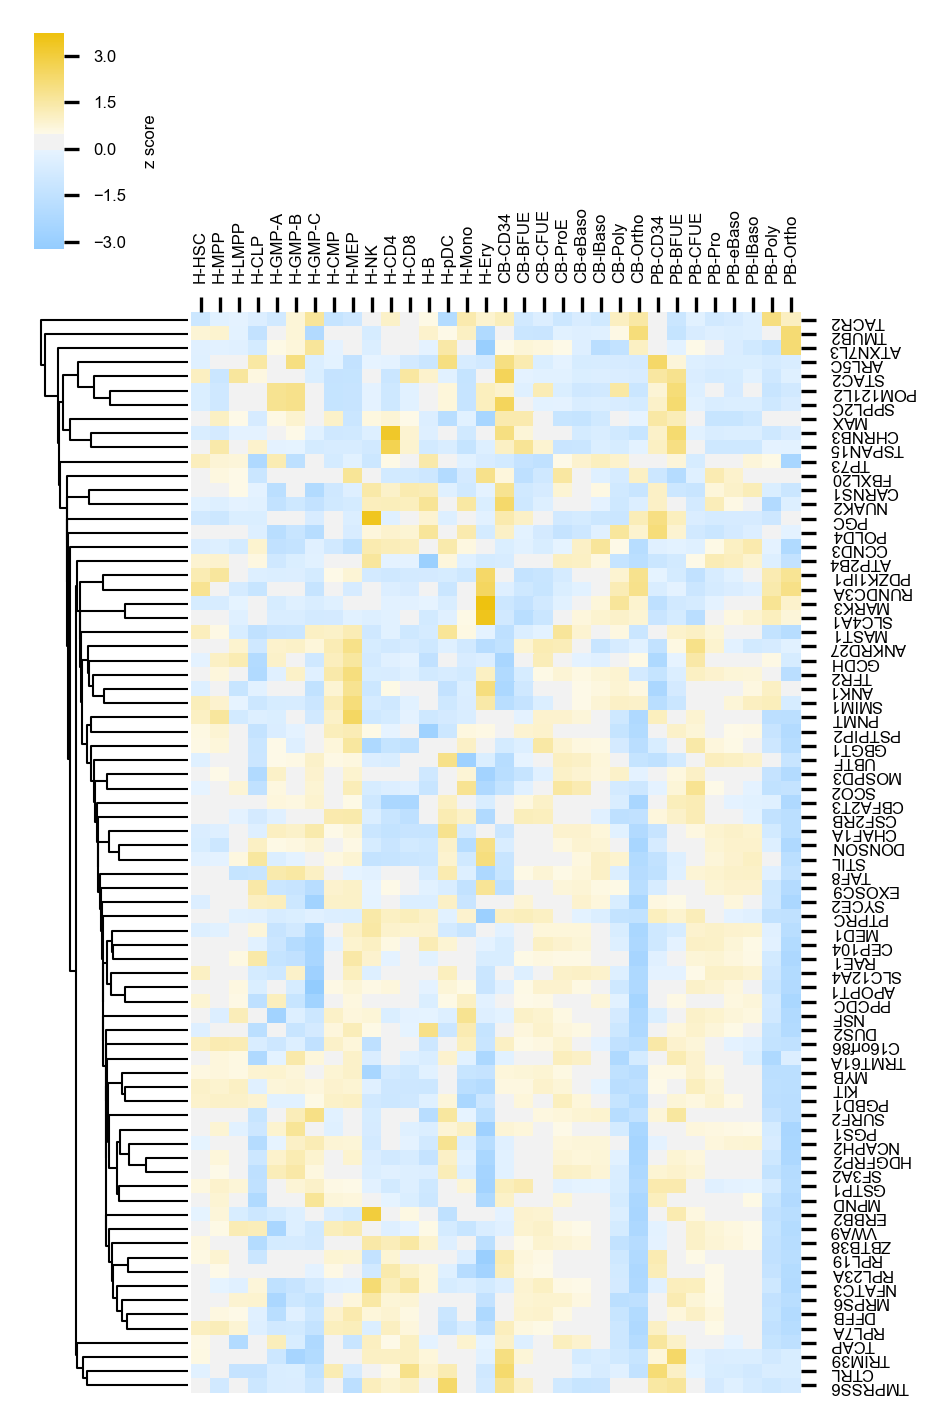

In [102]:
gfig = g.fig
axes = gfig.get_axes()

axes[2].tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)
axes[2].set_xticklabels(celltypes, rotation=90)

axes[2].set_yticks(np.arange(len(genes))+0.5)
try:
    axes[2].set_yticklabels(genes[g.dendrogram_row.reordered_ind], rotation=180)
except:
    axes[2].set_yticklabels(genes, rotation=180)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(4)
        item.set_fontname('Arial')
        
axes[3].set_ylabel('z score', fontname='Arial')

gfig.set_dpi(300)
gfig.set_size_inches((0.1 * indf.shape[1], 6))

gfig

## Permute stage-specific enrichments (3F)

In [103]:
screenGenes = [x for x in shref[shref['type'] == 'gwa']['gene'].unique() if x in alldf['gene'].values]
screenGenes = sorted(screenGenes)
print(len(screenGenes))

383


In [104]:
screendf = alldf[alldf['gene'].isin(screenGenes)].copy()
samplePool = screendf['H-HSC'].values
test = np.random.choice(samplePool, 76)
len(test)
for x in test:
    if x not in samplePool:
        print('False')

In [105]:
screendf = alldf[alldf['gene'].isin(screenGenes)].copy()

PERMS = 1000000
numHits = len([x for x in trueHits if x in alldf['gene'].values])
print(PERMS, numHits)

cellTypes = []
benches = []
permps = []

for col in screendf.columns[1:]:
    cellTypes.append(col)
    bench = screendf[screendf['gene'].isin(trueHits)][col].values.sum()
    benches.append(bench)
    
    extremes = 0
    samplePool = screendf[col].values
    for p in range(PERMS):
        if np.random.choice(samplePool, numHits).sum() > bench:
            extremes += 1
            
    permps.append(extremes/PERMS)
    
permdf = pd.DataFrame()
permdf['ctype'] = cellTypes
permdf['bench'] = benches
permdf['permp'] = permps

1000000 76


-3.25030872616 3.7186974682


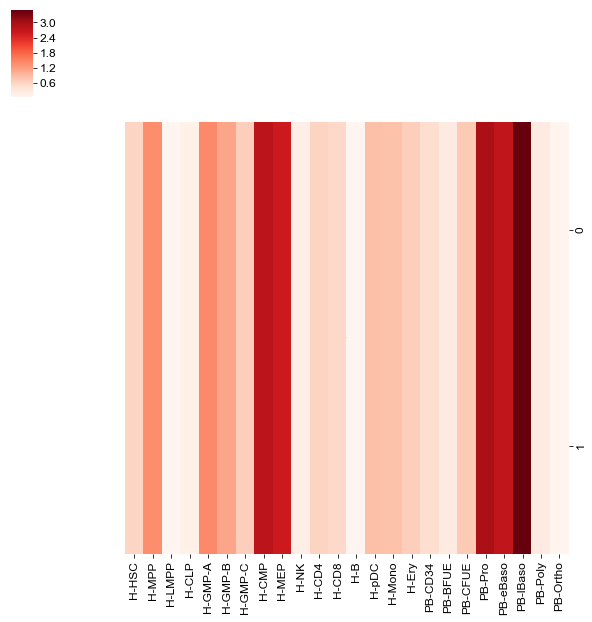

In [106]:
cMin = indf[[x for x in indf.columns[1:]]].values.min().min()
cMax = indf[[x for x in indf.columns[1:]]].values.max().max()
print(cMin, cMax)

findValsNames = permdf[-permdf['ctype'].str.contains('CB-')]['ctype'].values
findVals = -np.log(permdf[-permdf['ctype'].str.contains('CB-')]['permp'].values)
dummy = [list(findVals), list(findVals)]

C = sns.diverging_palette(240, 65, s=99, l=80, sep=20, center='light', as_cmap=True)
dFig = sns.clustermap(pd.DataFrame(dummy), cmap='Reds', col_cluster=False, row_cluster=False, method='single')

dFig = dFig.fig
axes = dFig.get_axes()
axes[2].set_xticks(np.arange(len(findValsNames))+0.5)
axes[2].set_xticklabels(findValsNames, rotation=90)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
        item.set_fontname('Arial')

In [107]:
permdf.sort_values('permp')

,ctype,bench,permp
29,PB-lBaso,17.288926,0.030966
27,PB-Pro,24.594323,0.050611
7,H-CMP,22.317011,0.060614
28,PB-eBaso,20.342867,0.064188
20,CB-eBaso,23.266579,0.067655
8,H-MEP,31.300310,0.074296
19,CB-ProE,32.336225,0.084391
21,CB-lBaso,12.496047,0.109660
4,H-GMP-A,-10.542757,0.237398
1,H-MPP,24.984652,0.247647


In [108]:
screendf = alldf.copy()

PERMS = 100000
numHits = len([x for x in trueHits if x in alldf['gene'].values])
print(PERMS, numHits)

cellTypes = []
benches = []
permps = []

for col in screendf.columns[1:]:
    cellTypes.append(col)
    bench = screendf[screendf['gene'].isin(trueHits)][col].values.sum()
    benches.append(bench)
    
    extremes = 0
    samplePool = screendf[col].values
    for p in range(PERMS):
        if np.random.choice(samplePool, numHits).sum() > bench:
            extremes += 1
            
    permps.append(extremes/PERMS)
    
permAlldf = pd.DataFrame()
permAlldf['ctype'] = cellTypes
permAlldf['bench'] = benches
permAlldf['permp'] = permps

100000 76


In [109]:
permAlldf.sort_values('permp')

,ctype,bench,permp
20,CB-eBaso,23.266579,0.00004
21,CB-lBaso,12.496047,0.00011
29,PB-lBaso,17.288926,0.00021
8,H-MEP,31.300310,0.00026
27,PB-Pro,24.594323,0.00043
28,PB-eBaso,20.342867,0.00073
19,CB-ProE,32.336225,0.00227
7,H-CMP,22.317011,0.00684
22,CB-Poly,-28.979492,0.02233
1,H-MPP,24.984652,0.03493


# Splicing Analysis (6E)

In [110]:
a2FileNames = sorted(glob('ref/splicingData/a2/*'))
b1FileNames = sorted(glob('ref/splicingData/b1/*'))
geneLims = pd.read_csv('ref/splicingData/geneLims.csv')

annos = ['A3SS', 'A5SS', 'MXE', 'RI', 'SE']

In [111]:
geneNameLookup = pd.read_csv('ref/splicingData/geneLocationRefMart.txt', sep='\t', dtype={5:str})
geneNameLookup.head()
geneNameLookup = geneNameLookup.set_index('Gene stable ID').to_dict()['HGNC symbol']

In [112]:
a2DE = pd.read_csv('ref/splicingData/de/a2_DESeq2.csv', sep=',')
b1DE = pd.read_csv('ref/splicingData/de/b1_DESeq2.csv', sep=',')

a2Genes = []
b1Genes = []

for gene in a2DE['Unnamed: 0'].values:
    gene = gene[:gene.find('.')]
    try:
        a2Genes.append(geneNameLookup[gene])
    except:
        a2Genes.append('')

for gene in b1DE['Unnamed: 0'].values:
    gene = gene[:gene.find('.')]
    try:
        b1Genes.append(geneNameLookup[gene])
    except:
        b1Genes.append('')
        
a2DE['gene'] = a2Genes
b1DE['gene'] = b1Genes

a2DE = a2DE.sort_values('padj')
b1DE = b1DE.sort_values('padj')

a2DEgenes = a2DE[a2DE['padj'] < 0.05]['gene'].values
b1DEgenes = b1DE[b1DE['padj'] < 0.05]['gene'].values
print(len(a2DEgenes), len(b1DEgenes))

7193 996


In [113]:
a2DEgenes = [x for x in list(set(a2DEgenes)) if type(x) == str and x != '']
len(a2DEgenes)

b1DEgenes = [x for x in list(set(b1DEgenes)) if type(x) == str and x != '']
len(b1DEgenes)

807

In [114]:
firstRE = re.compile('[a-zA-z0-9]*[\-:](\d*)[\-:]')
secondRE = re.compile('.*[\-:](\d*):[\-+]')

In [115]:
a2RawEvents = []
a2RawFails = []
for fileName in a2FileNames:
    temp = pd.read_csv(fileName, sep='\t')
    temp = temp[temp['bayes_factor'] > 10.0]
    a2RawEvents.append(temp.shape[0])
    geneLimsSub = geneLims[geneLims['gene'].isin(a2DEgenes)].copy()
    
    strands = []
    chrs = []
    starts = []
    ends = []
    for event in temp['event_name'].values:
        strands.append(event[-1])
        chrs.append(event[:event.find(':')])
        starts.append(int(re.search(firstRE, event).group(1)))
        ends.append(int(re.search(secondRE, event).group(1)))

    fails = []
    for i,event in enumerate(temp['event_name'].values):
        strand = strands[i]
        chro = chrs[i]
        start = starts[i]
        end = ends[i]
        tempsub = geneLimsSub[(geneLimsSub['strand'] == strand) & (geneLimsSub['chr'] == chro)].copy()

        tempStarts = tempsub['gStart'].values
        tempEnds = tempsub['gEnd'].values

        for j in range(len(tempStarts)):
            gStart = tempStarts[j]
            gEnd = tempEnds[j]
            if start <= gEnd and end >= gStart:
                fails.append(event)
                break
            else:
                pass
            
    a2RawFails.append(len(fails))
    print(fileName, temp.shape[0], len(fails))

ref/splicingData/a2/A3SS_vs_A3SS.miso_bf 182 101
ref/splicingData/a2/A5SS_vs_A5SS.miso_bf 129 70
ref/splicingData/a2/MXE_vs_MXE.miso_bf 444 250
ref/splicingData/a2/RI_vs_RI.miso_bf 563 350
ref/splicingData/a2/SE_vs_SE.miso_bf 468 260


In [116]:
b1RawEvents = []
b1RawFails = []
for fileName in b1FileNames:
    temp = pd.read_csv(fileName, sep='\t')
    temp = temp[temp['bayes_factor'] > 10.0]
    #temp = temp[temp['diff'].abs() > 0.05]
    #print(temp.event_name.values[1])
    #print(re.search(firstRE, temp.event_name.values[1]).group(1))
    #print(re.search(secondRE, temp.event_name.values[1]).group(1))
    b1RawEvents.append(temp.shape[0])
    geneLimsSub = geneLims[geneLims['gene'].isin(b1DEgenes)].copy()
    
    strands = []
    chrs = []
    starts = []
    ends = []
    for event in temp['event_name'].values:
        strands.append(event[-1])
        chrs.append(event[:event.find(':')])
        starts.append(int(re.search(firstRE, event).group(1)))
        ends.append(int(re.search(secondRE, event).group(1)))

    fails = []
    for i,event in enumerate(temp['event_name'].values):
        strand = strands[i]
        chro = chrs[i]
        start = starts[i]
        end = ends[i]
        tempsub = geneLimsSub[(geneLimsSub['strand'] == strand) & (geneLimsSub['chr'] == chro)].copy()

        tempStarts = tempsub['gStart'].values
        tempEnds = tempsub['gEnd'].values

        for j in range(len(tempStarts)):
            gStart = tempStarts[j]
            gEnd = tempEnds[j]
            if start <= gEnd and end >= gStart:
                fails.append(event)
                break
            else:
                pass
            
    b1RawFails.append(len(fails))
    print(fileName, temp.shape[0], len(fails))

ref/splicingData/b1/A3SS_vs_A3SS.miso_bf 431 12
ref/splicingData/b1/A5SS_vs_A5SS.miso_bf 201 8
ref/splicingData/b1/MXE_vs_MXE.miso_bf 1181 45
ref/splicingData/b1/RI_vs_RI.miso_bf 499 24
ref/splicingData/b1/SE_vs_SE.miso_bf 1157 48


In [117]:
a2RawEvents = list(np.array(a2RawEvents) - np.array(a2RawFails))
b1RawEvents = list(np.array(b1RawEvents) - np.array(b1RawFails))
print(a2RawEvents, b1RawEvents)

[81, 59, 194, 213, 208] [419, 193, 1136, 475, 1109]


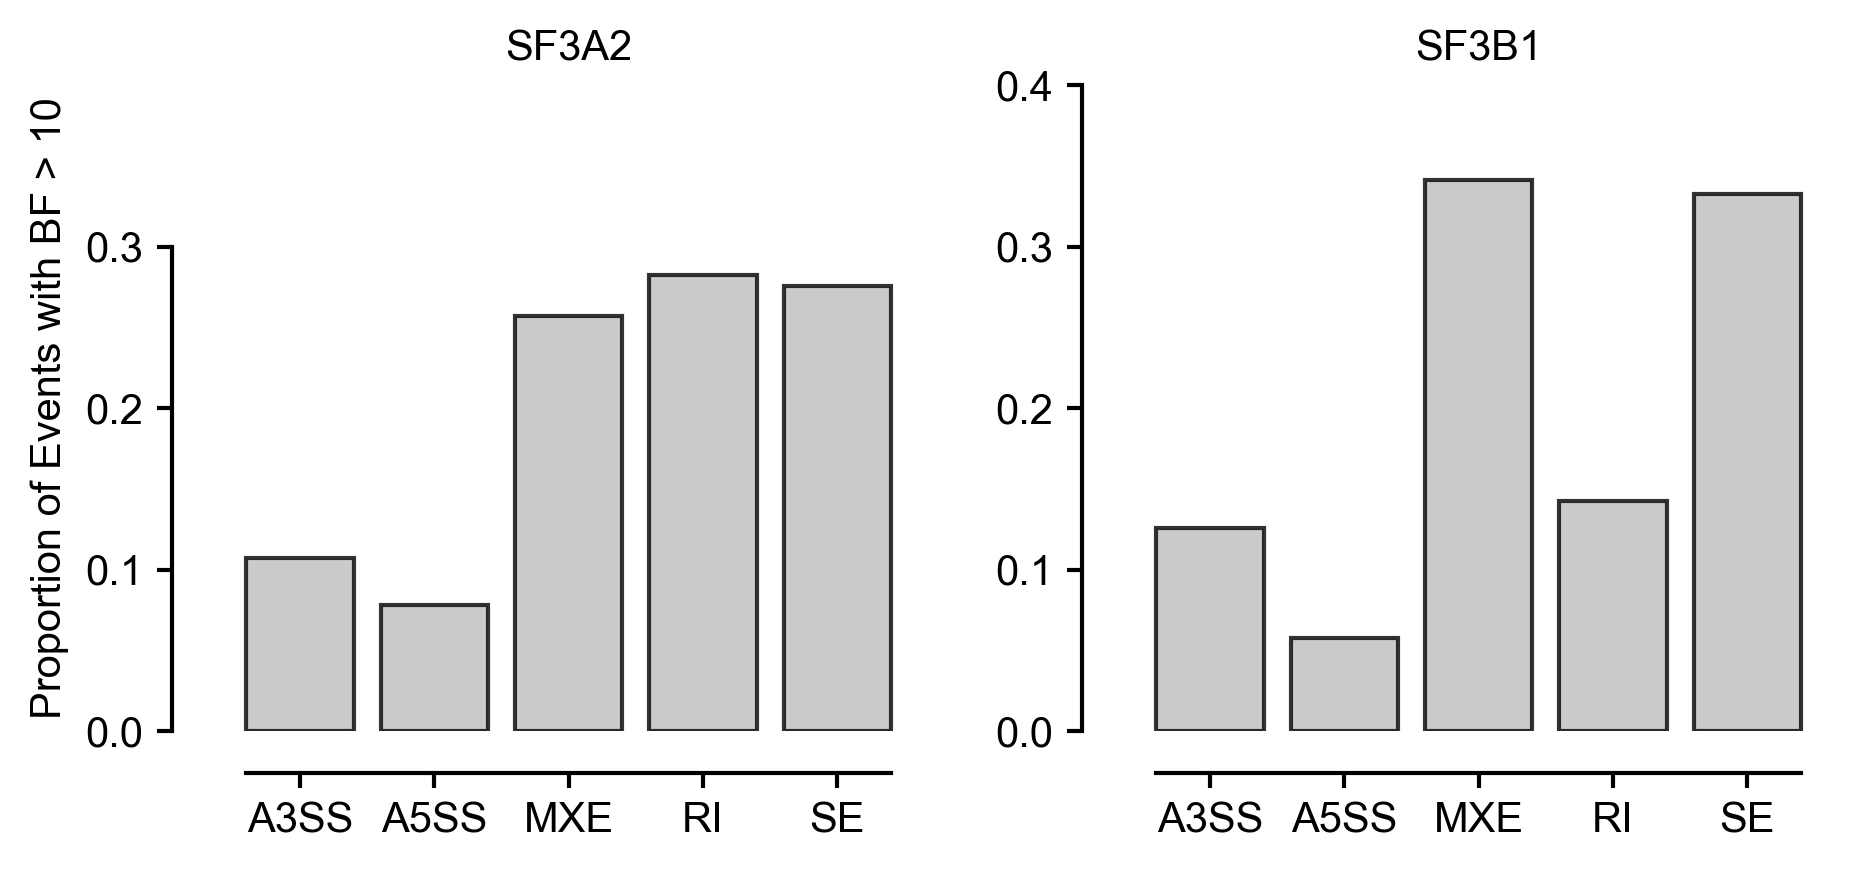

In [118]:
fig, axes = plt.subplots(1,2, figsize=(6.4, 3), dpi=300)

inds = [1, 2, 3, 4, 5]

ax = axes[0]
ax.bar(inds, np.array(a2RawEvents)/np.array(a2RawEvents).sum(), color='0.75', alpha=0.8, edgecolor='black')
ax.set_xticks(inds)
ax.set_xticklabels(annos, rotation=45)
ax.set_title('SF3A2')
ax.set_ylim(0, 0.4)
ax.set_ylabel('Proportion of Events with BF > 10')

adjust_spines(ax, ['left', 'bottom'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

ax = axes[1]
ax.bar(inds, np.array(b1RawEvents)/np.array(b1RawEvents).sum(), color='0.75', alpha=0.8,  edgecolor='black')
ax.set_xticks(inds)
ax.set_xticklabels(annos, rotation=45)
ax.set_title('SF3B1')
ax.set_ylim(0, 0.4)

adjust_spines(ax, ['left', 'bottom'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
    item.set_fontname('Arial')

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

plt.tight_layout()

# Patient Hb Analysis (S6H)

In [119]:
df = pd.read_csv('ref/patientHbData/patientHeme.csv')
df = df[~np.isnan(df['Hemog'])].copy()
print(df.shape)
df.head(3)

(126, 12)


,ID,Dx,Hemog,Genotype,Start,End,Ref,Alt,Gene.refGene,AAChange.refGene,ExAC_ALL,snp138
0,C118,AA,9.0,0/0,2138654,2138654,T,G,AP3D1,NM_001261826:c.A156C:p.I52I,0.3408,rs25672
1,C87,AA/PNH; HL,13.0,"0/1:43,50:93:99:1397,0,1252",2138654,2138654,T,G,AP3D1,NM_001261826:c.A156C:p.I52I,0.3408,rs25672
3,C112,AML,11.1,"1/1:0,152:152:99:4924,376,0",2138654,2138654,T,G,AP3D1,NM_001261826:c.A156C:p.I52I,0.3408,rs25672


In [120]:
types = [x[:3] for x in df['Genotype'].values]
print(len(types))
df.loc[:,'types'] = types
listOfTypes = sorted(list(set(types)))
print(listOfTypes)

126
['0/0', '0/1', '1/1']


In [121]:
df = df[df['Dx'].str.contains('MDS')]

genoLookup = {'0/0':0, '0/1':1, '1/1':2}

df.loc[:,'types'] = np.array([genoLookup[x] for x in df['types'].values])

df = df.sort_values('types')
df.shape

(94, 13)

In [122]:
def qnorm(x):
    x = x.flatten()
    x = np.array(rankdata(x))
    x -= 0.5
    x /= len(x)
    x = norm.ppf(x)
    return(x)

In [123]:
df['qnorm'] = qnorm(df['Hemog'].values)

df['qnormByGeno'] = np.concatenate((qnorm(df[df['types'] == 0]['Hemog'].values),
                                       qnorm(df[df['types'] == 1]['Hemog'].values),
                                       qnorm(df[df['types'] == 2]['Hemog'].values)))

In [124]:
xVals = df['types'].values
yVals = df['qnorm'].values

xVals = xVals.reshape(-1,1)
yVals = yVals.reshape(-1,1)

In [125]:
xVals2 = sm.add_constant(xVals)
est = sm.OLS(yVals, xVals2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.154
Date:                Wed, 06 Mar 2019   Prob (F-statistic):              0.146
Time:                        18:48:13   Log-Likelihood:                -131.57
No. Observations:                  94   AIC:                             267.1
Df Residuals:                      92   BIC:                             272.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1787      0.159     -1.123      0.2

In [126]:
def statsLM (x):
    return -0.1787 + 0.2335 * np.array(x)

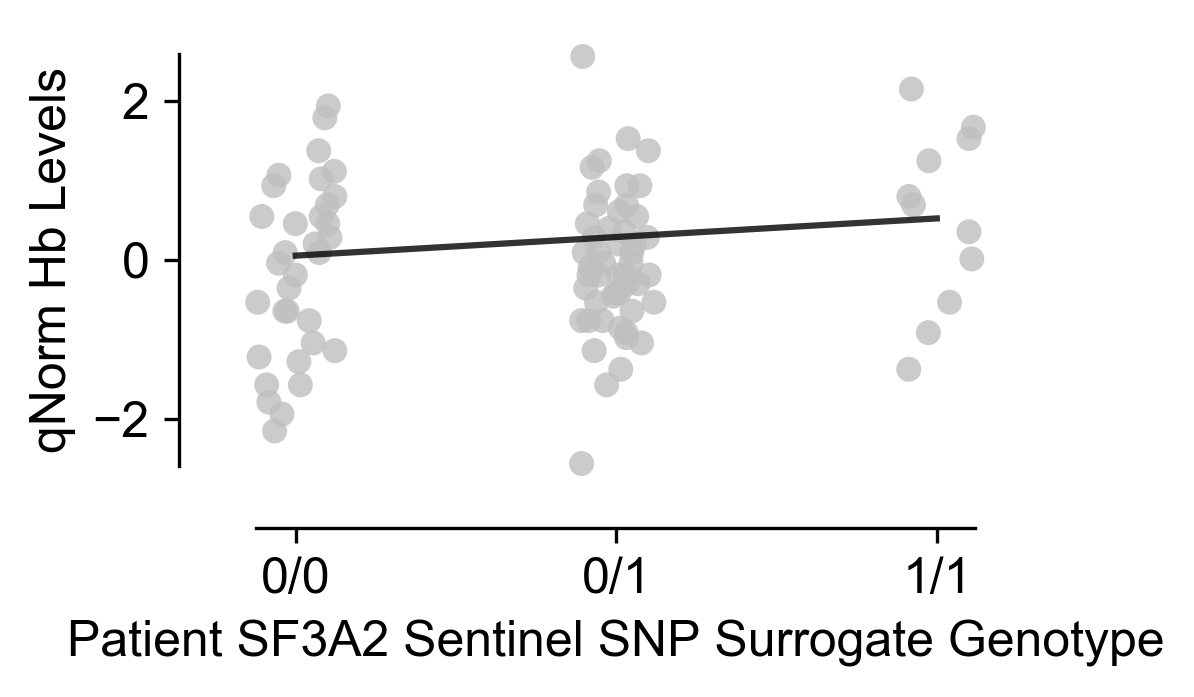

In [127]:
numGenos = len(listOfTypes)

fig, ax = plt.subplots(1, dpi=300, figsize=(3.4,2))

ax.scatter([1 + (random()-0.5)*0.25 for i in range(len(df[df['types'] == 0]))], df[df['types'] == 0]['qnorm'].values, alpha=0.8, color='0.75', edgecolor='none')
ax.scatter([2 + (random()-0.5)*0.25 for i in range(len(df[df['types'] == 1]))], df[df['types'] == 1]['qnorm'].values, alpha=0.8, color='0.75', edgecolor='none')
ax.scatter([3 + (random()-0.5)*0.25 for i in range(len(df[df['types'] == 2]))], df[df['types'] == 2]['qnorm'].values, alpha=0.8, color='0.75', edgecolor='none')

adjust_spines(ax, ['bottom', 'left'])

ax.set_xlabel('Patient SF3A2 Sentinel SNP Surrogate Genotype')
ax.set_ylabel('qNorm Hb Levels')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
    item.set_fontname('Arial')

ax.set_xticks([1,2,3])
ax.set_xticklabels(listOfTypes)

ax.plot([1, 2, 3], statsLM([1, 2, 3]), color='black', alpha=0.8)